# Imports

In [1]:
import pickle
import torch
import random
import math
import os
import h5py
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2.functional as T
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, transforms
from torchvision.utils import make_grid
from torchsummary import summary
from torchvision.transforms import v2
from google.colab import drive
from google.colab import runtime
from PIL import Image
!pip install torchinfo
!pip install tensorboard
from torchinfo import summary
drive.mount('/content/drive')

Mounted at /content/drive


# Data

File Loading

In [2]:
# Load training data from HDF5 file
with h5py.File('/content/drive/My Drive/AV Research/train_data.h5', 'r') as train_file:
    train_data = np.array(train_file['data'])
    train_labels = np.array(train_file['labels'])

# Load validation data from HDF5 file
with h5py.File('/content/drive/My Drive/AV Research/val_data.h5', 'r') as val_file:
    val_data = np.array(val_file['data'])
    val_labels = np.array(val_file['labels'])

Dataset Mean/Std

In [3]:
# From: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def dataset_mean_std(data_loader):
  nimages = 0
  mean = 0.
  std = 0.
  for batch, _ in data_loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      # Update total number of images
      nimages += batch.size(0)
      # Compute mean and std here
      mean += batch.float().mean(2).sum(0)
      std += batch.float().std(2).sum(0)

  # Final step
  mean /= nimages
  std /= nimages

  print("Training set mean", mean)
  print("Training set std", std)

  return mean, std

def get_mean_std(data):
  mean = np.mean(data, axis=(0, 1, 2))
  std = np.std(data, axis=(0, 1, 2))
  return mean, std

Data Augmentation

In [4]:
# from: https://github.com/TheRoboticsClub/gsoc2023-Meiqi_Zhao/tree/main
class ShiftAndAdjustSteer(object):
    def __init__(self, shift_fraction=0.1, steer_adjust=1.0, p=0.5):
        self.shift_fraction = shift_fraction
        self.steer_adjust = steer_adjust
        self.p = p

    def __call__(self, image, output):
        if random.random() < self.p:
            # sample a random shift
            max_shift_px = self.shift_fraction * image.shape[2]
            shift_px = torch.tensor([random.uniform(-max_shift_px, max_shift_px), 0])

            # apply the shift to the images
            shifted_img = T.affine(image, angle=0, translate=shift_px.tolist(), scale=1, shear=0, interpolation=T.InterpolationMode.NEAREST)

            # adjust the steering angle according to the shift
            shift_fraction = shift_px[0] / image.shape[2]
            shifted_steer = output[0] + self.steer_adjust * shift_fraction
            shifted_steer = torch.clamp(shifted_steer, -1.0, 1.0)

            image = shifted_img
            output[0] = shifted_steer

        return image, output

class RandomHorizontalFlipWithSteeringAngle(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, input, output):
        if random.random() < self.p:
            v2.functional.hflip(input)
            output[0] = -output[0]
        return input, output

In [5]:
class TrainDataAugmentation(nn.Module):
    def __init__(self):
        super(TrainDataAugmentation, self).__init__()
        self.transforms = v2.Compose([
            v2.Resize((59, 128)),
            v2.ToPILImage(),
            # v2.RandomAffine(degrees=0, translate=(0.2, 0.2)),
            # v2.RandomRotation(degrees=45),
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
            v2.Normalize(mean=(0.4872, 0.4669, 0.4469,), std=(0.1138, 0.1115, 0.1074,)),
        ])

    def forward(self, image):
        augmented_image = self.transforms(image)
        return augmented_image

class ValDataAugmentation(nn.Module):
    def __init__(self):
        super(ValDataAugmentation, self).__init__()
        self.transforms = v2.Compose([
            v2.Resize((59, 128)),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
            v2.Normalize(mean=(0.4872, 0.4669, 0.4469,), std=(0.1138, 0.1115, 0.1074,)),
        ])

    def forward(self, image):
        augmented_image = self.transforms(image)
        return augmented_image

Data Preprocessing

In [6]:
class AVDataset(Dataset):
    def __init__(self, input_images, control_values, resize, transform):
        self.input_images = input_images
        self.control_values = control_values
        self.resize = resize
        self.transform = transform

    def __len__(self):
        return len(self.control_values)

    def __getitem__(self, idx):
        input_image = self.input_images[idx]
        control_value = self.control_values[idx]

        input_image = torch.tensor(input_image).permute(2, 0, 1)

        if self.resize:
            input_image = T.resize(input_image, (59, 128))

        if self.transform:
            input_image, control_value = ShiftAndAdjustSteer(shift_fraction=0.15, steer_adjust=1.0, p=0.5)(input_image, control_value)
            input_image = v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=None, hue=None)(input_image)
            input_image = v2.RandomApply(torch.nn.ModuleList([v2.GaussianBlur(kernel_size=5, sigma=(0.1, 2.)),]), p=0.5)(input_image)

        input_image = input_image / 255.0
        input_image = v2.Normalize(mean=(0.4872, 0.4669, 0.4469,), std=(0.1138, 0.1115, 0.1074,))(input_image)
        control_value = torch.tensor([(control_value[0]+ 1.0) / 2.0, (control_value[1] - control_value[2] + 1.0) / 2.0])

        return input_image, control_value

train_dataset = AVDataset(input_images=train_data, control_values=train_labels, resize=True, transform=True)
val_dataset = AVDataset(input_images=val_data, control_values=val_labels, resize=True, transform=False)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


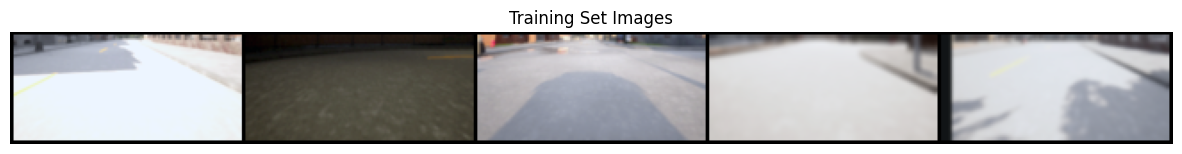

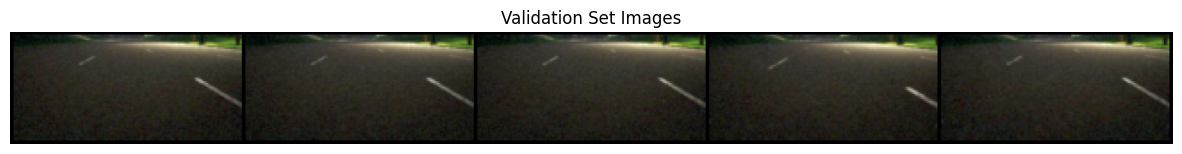

In [7]:
def show_images(images, nrow=5, title=None):
    grid = make_grid(images, nrow=nrow, normalize=True)
    npimg = grid.numpy()
    plt.figure(figsize=(15, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def plot_images_from_loader(loader, title):
    # Get a batch of images
    dataiter = iter(loader)
    images, _ = next(dataiter)
    batch_size = images.shape[0]

    # Select 5 random indices
    random_indices = random.sample(range(batch_size), 5)
    random_images = images[random_indices]

    # Call the helper function to show images
    show_images(random_images, title=title)


# Assuming train_loader and val_loader are defined
plot_images_from_loader(train_loader, title="Training Set Images")
plot_images_from_loader(val_loader, title="Validation Set Images")

# Model

Positional Encoding

In [8]:
# From: https://github.com/wzlxjtu/PositionalEncoding2D
class PositionalEncoding2d(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2d, self).__init__()
        if d_model % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(d_model))
        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                            -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

Separable Convolution 2D Layer

In [9]:
# Inspired by: https://github.com/reshalfahsi/separableconv-torch
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

Residual Block

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, num_layers: int, pool: bool, short: bool):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.pooling = pool
        self.short = short

        self.inconv = nn.Sequential(
            SeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size),
            nn.SELU()
        )

        layers = []
        for _ in range(num_layers - 1):
            layers.append(SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size))
            layers.append(nn.SELU())
        self.convlayers = nn.Sequential(*layers)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1)
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
        else:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

        self.sact = nn.SELU()

    def forward(self, x):
        out = self.inconv(x)
        out = self.convlayers(out)

        if self.pooling:
            out = self.pool(out)

        if self.short:
            shortcut = self.shortcut(x)
            out = out + shortcut
            out = self.sact(out)

        return out

AV Model

In [40]:
class AVModel(nn.Module):
    def __init__(self):
        super(AVModel, self).__init__()
        # self.norm = nn.LayerNorm(64)
        # self.attention = nn.MultiheadAttention(embed_dim=64, num_heads=1, dropout=0.5, batch_first=True)
        # self.scale = nn.Parameter(torch.zeros(1))

        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, bias=False),
            nn.SELU(),
        )

        self.conv_layers = nn.Sequential(
            ResidualBlock(in_channels=64, out_channels=64, kernel_size=3, num_layers=2, pool=True, short=True),
            nn.Dropout2d(0.2),
            ResidualBlock(in_channels=64, out_channels=128, kernel_size=3, num_layers=2, pool=True, short=True),
            nn.Dropout2d(0.2),
            ResidualBlock(in_channels=128, out_channels=256, kernel_size=3, num_layers=2, pool=True, short=True),
            nn.Dropout2d(0.2),
        )

        self.dense_layers = nn.Sequential(
            nn.Linear(256, 50, bias=False),
            nn.SELU(),
            nn.Linear(50, 10, bias=False),
            nn.SELU(),
            nn.Dropout(0.5),
        )

        self.output_layer = nn.Linear(10, 2)

    def forward(self, x):
        # batch_size, channels, height, width = x.size()
        # x_att = x.reshape(batch_size, channels, height * width).transpose(1, 2)
        # x_att = self.norm(x_att)
        # attention_output, _ = self.attention(x_att, x_att, x_att)
        # attention_output = attention_output.transpose(1, 2).reshape(batch_size, channels, height, width)
        # x = self.scale * attention_output + x

        x = self.input_layer(x)
        x = self.conv_layers(x)
        x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2) # GlobalAveragePooling2D
        x = self.dense_layers(x)
        x = self.output_layer(x)
        out = torch.sigmoid(x)
        return out

# Util

MFPE Loss

In [12]:
class MFPELoss(nn.Module):
    def __init__(self):
        super(MFPELoss, self).__init__()

    def forward(self, input, target):
        error = input - target
        fourth_power_error = error ** 4
        mean_fourth_power_error = torch.mean(fourth_power_error)
        return mean_fourth_power_error

Early Stopping

In [13]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

Autoclip

In [14]:
# From: https://github.com/pseeth/autoclip/blob/master/autoclip.py
class AutoClip:
    def __init__(self, percentile):
        self.grad_history = []
        self.percentile = percentile

    def compute_grad_norm(self, model):
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        return total_norm

    def __call__(self, model):
        grad_norm = self.compute_grad_norm(model)
        self.grad_history.append(grad_norm)
        clip_value = np.percentile(self.grad_history, self.percentile)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

Model Checkpoint

In [15]:
def save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses):
  checkpoint = {
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'train_losses': train_losses,
          'val_losses': val_losses,
      }
  torch.save(checkpoint, f'/content/drive/My Drive/AV Research/Checkpoints/model_checkpoint_{epoch}.pt')

def load_checkpoint(filepath, model, optimizer, scheduler):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    return model, optimizer, scheduler, start_epoch, train_losses, val_losses

# Training Loop

In [41]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AVModel().to(device)
start_epoch = 0
num_epochs = 30
learning_rate = 5e-5

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=num_epochs)
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=5)

torch.autograd.set_detect_anomaly(False)
torch.backends.cudnn.benchmark = True
autoclipper = AutoClip(percentile=10)

writer = SummaryWriter()

train_losses = []
val_losses = []

print(summary(model, input_size=(batch_size, 3, 59, 128)))

# checkpoint_path = '/content/drive/My Drive/Projects/NeuraBeat/Checkpoints/model_checkpoint_6.pt'
# if os.path.isfile(checkpoint_path):
#     model, optimizer, scheduler, start_epoch, train_losses, val_losses = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
#     print(f"Loaded checkpoint from epoch {start_epoch}")

def train_loop(train_loader, model, criterion, optimizer, device):
    size = len(train_loader.dataset)
    model.train()
    train_loss = 0.0
    num_batches = len(train_loader)

    # Training loop
    for batch, (inputs, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs = inputs.float().to(device)
        targets = targets.float().to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        autoclipper(model)
        optimizer.step()

        train_loss += loss.item()
        if (batch + 1) % 100 == 0:
            loss, current = train_loss / (batch + 1), (batch + 1) * batch_size
            print(f"Training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss = train_loss / num_batches
    return train_loss

def val_loop(val_loader, model, criterion, device):
    model.eval()
    val_loss = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for batch, (inputs, targets) in enumerate(val_loader):
            inputs = inputs.float().to(device)
            targets = targets.float().to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

            if (batch + 1) % 200 == 0:
                print(f"Val Batch {batch + 1}")
                print(f"Outputs: {outputs[:3]})")
                print(f"Targets: {targets[:3]})")

    val_loss = val_loss / num_batches
    return val_loss

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, criterion, optimizer, device)
    val_loss = val_loop(val_loader, model, criterion, device)
    print(f"Train loss: {train_loss:>8f} - Val loss: {val_loss:>8f} \n")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    writer.add_scalar('Loss/train', train_loss, epoch+1)
    writer.add_scalar('Loss/val', val_loss, epoch+1)

    save_checkpoint(model, optimizer, scheduler, epoch+1, train_losses, val_losses)

    # if early_stopping.early_stop(val_loss):
    #     print(f"Early stopping after {epoch+1} epochs \n")
    #     print(f"Best val loss: {early_stopping.min_validation_loss} \n")
    #     break

    print("Last learning rate:", scheduler.get_last_lr())
    scheduler.step()

writer.close()

Layer (type:depth-idx)                        Output Shape              Param #
AVModel                                       [32, 2]                   --
├─Sequential: 1-1                             [32, 64, 55, 124]         --
│    └─Conv2d: 2-1                            [32, 64, 55, 124]         4,800
│    └─SELU: 2-2                              [32, 64, 55, 124]         --
├─Sequential: 1-2                             [32, 256, 7, 16]          --
│    └─ResidualBlock: 2-3                     [32, 64, 28, 62]          --
│    │    └─Sequential: 3-1                   [32, 64, 55, 124]         4,672
│    │    └─Sequential: 3-2                   [32, 64, 55, 124]         4,672
│    │    └─MaxPool2d: 3-3                    [32, 64, 28, 62]          --
│    │    └─Conv2d: 3-4                       [32, 64, 28, 62]          4,096
│    │    └─SELU: 3-5                         [32, 64, 28, 62]          --
│    └─Dropout2d: 2-4                         [32, 64, 28, 62]          --
│    └─R

  0%|          | 0/4350 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  2%|▏         | 102/4350 [00:05<03:28, 20.35it/s]

Training loss: 0.079920  [ 3200/139199]


  5%|▍         | 204/4350 [00:10<03:21, 20.54it/s]

Training loss: 0.079954  [ 6400/139199]


  7%|▋         | 304/4350 [00:15<03:15, 20.67it/s]

Training loss: 0.079217  [ 9600/139199]


  9%|▉         | 403/4350 [00:20<03:13, 20.43it/s]

Training loss: 0.079180  [12800/139199]


 12%|█▏        | 502/4350 [00:25<03:27, 18.55it/s]

Training loss: 0.078957  [16000/139199]


 14%|█▍        | 604/4350 [00:30<03:03, 20.42it/s]

Training loss: 0.078582  [19200/139199]


 16%|█▌        | 702/4350 [00:35<03:01, 20.15it/s]

Training loss: 0.078535  [22400/139199]


 18%|█▊        | 802/4350 [00:40<03:04, 19.21it/s]

Training loss: 0.078424  [25600/139199]


 21%|██        | 902/4350 [00:45<02:55, 19.62it/s]

Training loss: 0.078315  [28800/139199]


 23%|██▎       | 1002/4350 [00:51<02:55, 19.11it/s]

Training loss: 0.078267  [32000/139199]


 25%|██▌       | 1103/4350 [00:56<02:43, 19.85it/s]

Training loss: 0.078091  [35200/139199]


 28%|██▊       | 1203/4350 [01:01<02:46, 18.86it/s]

Training loss: 0.078049  [38400/139199]


 30%|██▉       | 1302/4350 [01:06<02:34, 19.77it/s]

Training loss: 0.077942  [41600/139199]


 32%|███▏      | 1403/4350 [01:11<02:33, 19.19it/s]

Training loss: 0.077894  [44800/139199]


 35%|███▍      | 1502/4350 [01:16<02:22, 20.04it/s]

Training loss: 0.077870  [48000/139199]


 37%|███▋      | 1603/4350 [01:21<02:15, 20.33it/s]

Training loss: 0.077820  [51200/139199]


 39%|███▉      | 1703/4350 [01:26<02:10, 20.32it/s]

Training loss: 0.077751  [54400/139199]


 41%|████▏     | 1802/4350 [01:31<02:07, 20.03it/s]

Training loss: 0.077716  [57600/139199]


 44%|████▎     | 1902/4350 [01:36<02:05, 19.55it/s]

Training loss: 0.077662  [60800/139199]


 46%|████▌     | 2002/4350 [01:41<02:00, 19.55it/s]

Training loss: 0.077574  [64000/139199]


 48%|████▊     | 2104/4350 [01:47<01:50, 20.26it/s]

Training loss: 0.077534  [67200/139199]


 51%|█████     | 2202/4350 [01:52<01:47, 19.91it/s]

Training loss: 0.077447  [70400/139199]


 53%|█████▎    | 2302/4350 [01:57<01:41, 20.25it/s]

Training loss: 0.077403  [73600/139199]


 55%|█████▌    | 2402/4350 [02:02<01:39, 19.58it/s]

Training loss: 0.077358  [76800/139199]


 58%|█████▊    | 2503/4350 [02:07<01:31, 20.15it/s]

Training loss: 0.077330  [80000/139199]


 60%|█████▉    | 2603/4350 [02:12<01:31, 19.05it/s]

Training loss: 0.077255  [83200/139199]


 62%|██████▏   | 2704/4350 [02:17<01:24, 19.57it/s]

Training loss: 0.077252  [86400/139199]


 64%|██████▍   | 2803/4350 [02:22<01:14, 20.72it/s]

Training loss: 0.077205  [89600/139199]


 67%|██████▋   | 2903/4350 [02:27<01:15, 19.26it/s]

Training loss: 0.077070  [92800/139199]


 69%|██████▉   | 3003/4350 [02:32<01:05, 20.43it/s]

Training loss: 0.076992  [96000/139199]


 71%|███████▏  | 3103/4350 [02:37<01:05, 19.18it/s]

Training loss: 0.076904  [99200/139199]


 74%|███████▎  | 3203/4350 [02:42<00:56, 20.30it/s]

Training loss: 0.076816  [102400/139199]


 76%|███████▌  | 3302/4350 [02:47<00:52, 20.11it/s]

Training loss: 0.076714  [105600/139199]


 78%|███████▊  | 3402/4350 [02:52<00:47, 19.94it/s]

Training loss: 0.076651  [108800/139199]


 81%|████████  | 3504/4350 [02:58<00:41, 20.27it/s]

Training loss: 0.076584  [112000/139199]


 83%|████████▎ | 3602/4350 [03:03<00:38, 19.39it/s]

Training loss: 0.076481  [115200/139199]


 85%|████████▌ | 3701/4350 [03:08<00:32, 20.26it/s]

Training loss: 0.076350  [118400/139199]


 87%|████████▋ | 3803/4350 [03:13<00:26, 20.29it/s]

Training loss: 0.076253  [121600/139199]


 90%|████████▉ | 3904/4350 [03:18<00:21, 20.65it/s]

Training loss: 0.076112  [124800/139199]


 92%|█████████▏| 4004/4350 [03:23<00:16, 20.68it/s]

Training loss: 0.075988  [128000/139199]


 94%|█████████▍| 4104/4350 [03:28<00:12, 20.00it/s]

Training loss: 0.075889  [131200/139199]


 97%|█████████▋| 4202/4350 [03:33<00:07, 20.81it/s]

Training loss: 0.075766  [134400/139199]


 99%|█████████▉| 4303/4350 [03:38<00:02, 19.66it/s]

Training loss: 0.075613  [137600/139199]


100%|██████████| 4350/4350 [03:40<00:00, 19.69it/s]


Val Batch 200
Outputs: tensor([[0.5281, 0.6056],
        [0.5259, 0.5952],
        [0.5327, 0.6301]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4951, 0.4380],
        [0.5004, 0.4736],
        [0.5003, 0.4731]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5125, 0.5585],
        [0.5120, 0.5557],
        [0.5115, 0.5554]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.4922, 0.4415],
        [0.5019, 0.5032],
        [0.4959, 0.4766]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.075536 - Val loss: 0.060443 

Last learning rate: [5e-05]
Epoch 2
----------------

  2%|▏         | 102/4350 [00:05<03:41, 19.15it/s]

Training loss: 0.069066  [ 3200/139199]


  5%|▍         | 203/4350 [00:10<03:30, 19.68it/s]

Training loss: 0.068998  [ 6400/139199]


  7%|▋         | 304/4350 [00:15<03:18, 20.41it/s]

Training loss: 0.068515  [ 9600/139199]


  9%|▉         | 403/4350 [00:20<03:19, 19.81it/s]

Training loss: 0.068141  [12800/139199]


 12%|█▏        | 501/4350 [00:25<03:15, 19.65it/s]

Training loss: 0.068085  [16000/139199]


 14%|█▍        | 602/4350 [00:31<03:09, 19.75it/s]

Training loss: 0.068233  [19200/139199]


 16%|█▌        | 704/4350 [00:36<03:00, 20.24it/s]

Training loss: 0.068223  [22400/139199]


 18%|█▊        | 804/4350 [00:41<02:56, 20.13it/s]

Training loss: 0.068065  [25600/139199]


 21%|██        | 903/4350 [00:46<03:01, 18.99it/s]

Training loss: 0.068127  [28800/139199]


 23%|██▎       | 1002/4350 [00:51<02:47, 19.94it/s]

Training loss: 0.068239  [32000/139199]


 25%|██▌       | 1103/4350 [00:56<02:48, 19.32it/s]

Training loss: 0.068114  [35200/139199]


 28%|██▊       | 1203/4350 [01:01<02:36, 20.12it/s]

Training loss: 0.068052  [38400/139199]


 30%|██▉       | 1303/4350 [01:06<02:44, 18.55it/s]

Training loss: 0.067885  [41600/139199]


 32%|███▏      | 1403/4350 [01:11<02:25, 20.21it/s]

Training loss: 0.067806  [44800/139199]


 35%|███▍      | 1504/4350 [01:16<02:21, 20.17it/s]

Training loss: 0.067657  [48000/139199]


 37%|███▋      | 1602/4350 [01:21<02:14, 20.36it/s]

Training loss: 0.067558  [51200/139199]


 39%|███▉      | 1703/4350 [01:27<02:16, 19.35it/s]

Training loss: 0.067520  [54400/139199]


 41%|████▏     | 1804/4350 [01:32<02:05, 20.23it/s]

Training loss: 0.067307  [57600/139199]


 44%|████▍     | 1904/4350 [01:37<02:01, 20.16it/s]

Training loss: 0.067139  [60800/139199]


 46%|████▌     | 2003/4350 [01:42<02:01, 19.34it/s]

Training loss: 0.067059  [64000/139199]


 48%|████▊     | 2104/4350 [01:47<01:49, 20.55it/s]

Training loss: 0.066850  [67200/139199]


 51%|█████     | 2203/4350 [01:52<01:47, 19.94it/s]

Training loss: 0.066746  [70400/139199]


 53%|█████▎    | 2303/4350 [01:57<01:45, 19.39it/s]

Training loss: 0.066700  [73600/139199]


 55%|█████▌    | 2402/4350 [02:02<01:43, 18.74it/s]

Training loss: 0.066694  [76800/139199]


 58%|█████▊    | 2502/4350 [02:07<01:38, 18.72it/s]

Training loss: 0.066600  [80000/139199]


 60%|█████▉    | 2603/4350 [02:12<01:24, 20.66it/s]

Training loss: 0.066472  [83200/139199]


 62%|██████▏   | 2703/4350 [02:17<01:20, 20.37it/s]

Training loss: 0.066430  [86400/139199]


 64%|██████▍   | 2803/4350 [02:22<01:18, 19.75it/s]

Training loss: 0.066334  [89600/139199]


 67%|██████▋   | 2903/4350 [02:28<01:14, 19.36it/s]

Training loss: 0.066237  [92800/139199]


 69%|██████▉   | 3002/4350 [02:33<01:11, 18.95it/s]

Training loss: 0.066205  [96000/139199]


 71%|███████▏  | 3102/4350 [02:38<01:01, 20.25it/s]

Training loss: 0.066135  [99200/139199]


 74%|███████▎  | 3202/4350 [02:43<00:58, 19.55it/s]

Training loss: 0.066102  [102400/139199]


 76%|███████▌  | 3302/4350 [02:48<00:51, 20.39it/s]

Training loss: 0.066006  [105600/139199]


 78%|███████▊  | 3404/4350 [02:53<00:47, 20.07it/s]

Training loss: 0.065906  [108800/139199]


 81%|████████  | 3503/4350 [02:58<00:43, 19.47it/s]

Training loss: 0.065835  [112000/139199]


 83%|████████▎ | 3603/4350 [03:03<00:37, 20.04it/s]

Training loss: 0.065764  [115200/139199]


 85%|████████▌ | 3703/4350 [03:08<00:34, 18.57it/s]

Training loss: 0.065685  [118400/139199]


 87%|████████▋ | 3803/4350 [03:13<00:27, 19.62it/s]

Training loss: 0.065561  [121600/139199]


 90%|████████▉ | 3903/4350 [03:18<00:22, 19.61it/s]

Training loss: 0.065489  [124800/139199]


 92%|█████████▏| 4002/4350 [03:23<00:17, 20.23it/s]

Training loss: 0.065398  [128000/139199]


 94%|█████████▍| 4102/4350 [03:28<00:12, 19.81it/s]

Training loss: 0.065319  [131200/139199]


 97%|█████████▋| 4204/4350 [03:34<00:07, 19.64it/s]

Training loss: 0.065242  [134400/139199]


 99%|█████████▉| 4303/4350 [03:39<00:02, 19.46it/s]

Training loss: 0.065173  [137600/139199]


100%|██████████| 4350/4350 [03:41<00:00, 19.64it/s]


Val Batch 200
Outputs: tensor([[0.5139, 0.7285],
        [0.5139, 0.7251],
        [0.5151, 0.7547]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.5024, 0.4024],
        [0.5038, 0.4446],
        [0.5041, 0.4483]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5085, 0.6832],
        [0.5088, 0.6830],
        [0.5084, 0.6775]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5083, 0.5524],
        [0.5099, 0.6172],
        [0.5074, 0.5588]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.065149 - Val loss: 0.060186 

Last learning rate: [4.9863047384206835e-05]
Epoch 3

  2%|▏         | 102/4350 [00:05<03:33, 19.89it/s]

Training loss: 0.062555  [ 3200/139199]


  5%|▍         | 203/4350 [00:10<03:41, 18.73it/s]

Training loss: 0.062776  [ 6400/139199]


  7%|▋         | 303/4350 [00:15<03:23, 19.88it/s]

Training loss: 0.062482  [ 9600/139199]


  9%|▉         | 403/4350 [00:20<03:18, 19.89it/s]

Training loss: 0.062282  [12800/139199]


 12%|█▏        | 502/4350 [00:25<03:12, 19.95it/s]

Training loss: 0.062104  [16000/139199]


 14%|█▍        | 604/4350 [00:30<03:06, 20.05it/s]

Training loss: 0.061772  [19200/139199]


 16%|█▌        | 702/4350 [00:36<03:04, 19.77it/s]

Training loss: 0.061865  [22400/139199]


 18%|█▊        | 804/4350 [00:41<02:57, 19.94it/s]

Training loss: 0.062073  [25600/139199]


 21%|██        | 903/4350 [00:46<03:01, 18.97it/s]

Training loss: 0.061936  [28800/139199]


 23%|██▎       | 1002/4350 [00:51<02:47, 20.00it/s]

Training loss: 0.061892  [32000/139199]


 25%|██▌       | 1103/4350 [00:56<02:43, 19.83it/s]

Training loss: 0.061794  [35200/139199]


 28%|██▊       | 1202/4350 [01:01<02:34, 20.33it/s]

Training loss: 0.061762  [38400/139199]


 30%|██▉       | 1304/4350 [01:06<02:29, 20.33it/s]

Training loss: 0.061706  [41600/139199]


 32%|███▏      | 1402/4350 [01:11<02:57, 16.60it/s]

Training loss: 0.061675  [44800/139199]


 35%|███▍      | 1503/4350 [01:16<02:26, 19.44it/s]

Training loss: 0.061507  [48000/139199]


 37%|███▋      | 1604/4350 [01:21<02:14, 20.45it/s]

Training loss: 0.061518  [51200/139199]


 39%|███▉      | 1701/4350 [01:27<02:14, 19.69it/s]

Training loss: 0.061508  [54400/139199]


 41%|████▏     | 1803/4350 [01:32<02:06, 20.08it/s]

Training loss: 0.061426  [57600/139199]


 44%|████▎     | 1902/4350 [01:37<02:04, 19.70it/s]

Training loss: 0.061308  [60800/139199]


 46%|████▌     | 2002/4350 [01:42<01:56, 20.17it/s]

Training loss: 0.061270  [64000/139199]


 48%|████▊     | 2103/4350 [01:47<01:56, 19.31it/s]

Training loss: 0.061253  [67200/139199]


 51%|█████     | 2202/4350 [01:52<01:50, 19.39it/s]

Training loss: 0.061235  [70400/139199]


 53%|█████▎    | 2302/4350 [01:57<01:44, 19.66it/s]

Training loss: 0.061196  [73600/139199]


 55%|█████▌    | 2404/4350 [02:02<01:34, 20.68it/s]

Training loss: 0.061138  [76800/139199]


 58%|█████▊    | 2502/4350 [02:07<01:31, 20.12it/s]

Training loss: 0.061066  [80000/139199]


 60%|█████▉    | 2603/4350 [02:12<01:30, 19.26it/s]

Training loss: 0.060960  [83200/139199]


 62%|██████▏   | 2704/4350 [02:18<01:19, 20.66it/s]

Training loss: 0.060956  [86400/139199]


 64%|██████▍   | 2803/4350 [02:22<01:18, 19.83it/s]

Training loss: 0.060899  [89600/139199]


 67%|██████▋   | 2902/4350 [02:28<01:16, 18.97it/s]

Training loss: 0.060870  [92800/139199]


 69%|██████▉   | 3002/4350 [02:33<01:10, 19.19it/s]

Training loss: 0.060821  [96000/139199]


 71%|███████▏  | 3104/4350 [02:38<01:01, 20.27it/s]

Training loss: 0.060787  [99200/139199]


 74%|███████▎  | 3203/4350 [02:43<00:58, 19.63it/s]

Training loss: 0.060713  [102400/139199]


 76%|███████▌  | 3302/4350 [02:48<00:55, 18.97it/s]

Training loss: 0.060690  [105600/139199]


 78%|███████▊  | 3402/4350 [02:53<00:50, 18.81it/s]

Training loss: 0.060570  [108800/139199]


 81%|████████  | 3503/4350 [02:58<00:44, 19.02it/s]

Training loss: 0.060512  [112000/139199]


 83%|████████▎ | 3603/4350 [03:04<00:37, 19.86it/s]

Training loss: 0.060453  [115200/139199]


 85%|████████▌ | 3703/4350 [03:09<00:32, 19.89it/s]

Training loss: 0.060380  [118400/139199]


 87%|████████▋ | 3803/4350 [03:14<00:27, 19.96it/s]

Training loss: 0.060320  [121600/139199]


 90%|████████▉ | 3903/4350 [03:19<00:23, 19.42it/s]

Training loss: 0.060276  [124800/139199]


 92%|█████████▏| 4004/4350 [03:24<00:17, 19.91it/s]

Training loss: 0.060246  [128000/139199]


 94%|█████████▍| 4103/4350 [03:29<00:12, 20.25it/s]

Training loss: 0.060182  [131200/139199]


 97%|█████████▋| 4203/4350 [03:34<00:06, 21.07it/s]

Training loss: 0.060121  [134400/139199]


 99%|█████████▉| 4302/4350 [03:39<00:02, 19.66it/s]

Training loss: 0.060063  [137600/139199]


100%|██████████| 4350/4350 [03:42<00:00, 19.58it/s]


Val Batch 200
Outputs: tensor([[0.5069, 0.7536],
        [0.5069, 0.7515],
        [0.5074, 0.7801]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4996, 0.4842],
        [0.5005, 0.5082],
        [0.5005, 0.5109]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5077, 0.8106],
        [0.5075, 0.8074],
        [0.5076, 0.8040]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5163, 0.7557],
        [0.5169, 0.7845],
        [0.5151, 0.7422]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.060015 - Val loss: 0.053554 

Last learning rate: [4.9453690018345144e-05]
Epoch 4

  2%|▏         | 104/4350 [00:05<03:26, 20.55it/s]

Training loss: 0.058711  [ 3200/139199]


  5%|▍         | 202/4350 [00:10<03:32, 19.54it/s]

Training loss: 0.058375  [ 6400/139199]


  7%|▋         | 302/4350 [00:15<03:31, 19.18it/s]

Training loss: 0.057819  [ 9600/139199]


  9%|▉         | 401/4350 [00:20<03:11, 20.60it/s]

Training loss: 0.058088  [12800/139199]


 12%|█▏        | 503/4350 [00:25<03:11, 20.10it/s]

Training loss: 0.058410  [16000/139199]


 14%|█▍        | 604/4350 [00:30<03:02, 20.47it/s]

Training loss: 0.058011  [19200/139199]


 16%|█▌        | 703/4350 [00:35<03:06, 19.55it/s]

Training loss: 0.057768  [22400/139199]


 18%|█▊        | 803/4350 [00:40<03:04, 19.24it/s]

Training loss: 0.057726  [25600/139199]


 21%|██        | 903/4350 [00:45<02:54, 19.75it/s]

Training loss: 0.057643  [28800/139199]


 23%|██▎       | 1003/4350 [00:50<02:54, 19.21it/s]

Training loss: 0.057697  [32000/139199]


 25%|██▌       | 1103/4350 [00:55<02:45, 19.64it/s]

Training loss: 0.057751  [35200/139199]


 28%|██▊       | 1202/4350 [01:00<02:43, 19.31it/s]

Training loss: 0.057662  [38400/139199]


 30%|██▉       | 1303/4350 [01:05<02:31, 20.09it/s]

Training loss: 0.057711  [41600/139199]


 32%|███▏      | 1404/4350 [01:11<02:23, 20.57it/s]

Training loss: 0.057710  [44800/139199]


 35%|███▍      | 1502/4350 [01:16<02:29, 19.03it/s]

Training loss: 0.057737  [48000/139199]


 37%|███▋      | 1601/4350 [01:20<02:17, 19.96it/s]

Training loss: 0.057707  [51200/139199]


 39%|███▉      | 1702/4350 [01:26<02:08, 20.54it/s]

Training loss: 0.057638  [54400/139199]


 41%|████▏     | 1803/4350 [01:31<02:13, 19.07it/s]

Training loss: 0.057675  [57600/139199]


 44%|████▎     | 1903/4350 [01:36<02:05, 19.47it/s]

Training loss: 0.057701  [60800/139199]


 46%|████▌     | 2001/4350 [01:41<01:56, 20.17it/s]

Training loss: 0.057621  [64000/139199]


 48%|████▊     | 2102/4350 [01:46<01:51, 20.24it/s]

Training loss: 0.057654  [67200/139199]


 51%|█████     | 2202/4350 [01:51<01:50, 19.39it/s]

Training loss: 0.057607  [70400/139199]


 53%|█████▎    | 2304/4350 [01:56<01:42, 20.06it/s]

Training loss: 0.057604  [73600/139199]


 55%|█████▌    | 2403/4350 [02:01<01:39, 19.48it/s]

Training loss: 0.057587  [76800/139199]


 58%|█████▊    | 2503/4350 [02:07<01:34, 19.52it/s]

Training loss: 0.057518  [80000/139199]


 60%|█████▉    | 2602/4350 [02:12<01:26, 20.15it/s]

Training loss: 0.057519  [83200/139199]


 62%|██████▏   | 2702/4350 [02:17<01:26, 19.14it/s]

Training loss: 0.057565  [86400/139199]


 64%|██████▍   | 2804/4350 [02:22<01:16, 20.09it/s]

Training loss: 0.057510  [89600/139199]


 67%|██████▋   | 2902/4350 [02:27<01:14, 19.50it/s]

Training loss: 0.057481  [92800/139199]


 69%|██████▉   | 3001/4350 [02:32<01:07, 20.05it/s]

Training loss: 0.057425  [96000/139199]


 71%|███████▏  | 3103/4350 [02:37<01:05, 19.03it/s]

Training loss: 0.057394  [99200/139199]


 74%|███████▎  | 3203/4350 [02:42<01:02, 18.48it/s]

Training loss: 0.057331  [102400/139199]


 76%|███████▌  | 3303/4350 [02:47<00:54, 19.10it/s]

Training loss: 0.057283  [105600/139199]


 78%|███████▊  | 3402/4350 [02:52<00:50, 18.92it/s]

Training loss: 0.057262  [108800/139199]


 81%|████████  | 3502/4350 [02:58<00:43, 19.32it/s]

Training loss: 0.057265  [112000/139199]


 83%|████████▎ | 3602/4350 [03:02<00:36, 20.40it/s]

Training loss: 0.057259  [115200/139199]


 85%|████████▌ | 3704/4350 [03:08<00:31, 20.38it/s]

Training loss: 0.057233  [118400/139199]


 87%|████████▋ | 3802/4350 [03:13<00:27, 19.69it/s]

Training loss: 0.057181  [121600/139199]


 90%|████████▉ | 3904/4350 [03:18<00:22, 20.05it/s]

Training loss: 0.057176  [124800/139199]


 92%|█████████▏| 4002/4350 [03:23<00:17, 19.88it/s]

Training loss: 0.057181  [128000/139199]


 94%|█████████▍| 4103/4350 [03:28<00:12, 19.19it/s]

Training loss: 0.057143  [131200/139199]


 97%|█████████▋| 4203/4350 [03:33<00:07, 19.73it/s]

Training loss: 0.057136  [134400/139199]


 99%|█████████▉| 4303/4350 [03:38<00:02, 19.56it/s]

Training loss: 0.057109  [137600/139199]


100%|██████████| 4350/4350 [03:40<00:00, 19.68it/s]


Val Batch 200
Outputs: tensor([[0.5074, 0.7753],
        [0.5074, 0.7757],
        [0.5082, 0.7912]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4985, 0.5162],
        [0.4996, 0.5224],
        [0.4999, 0.5403]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5074, 0.8025],
        [0.5066, 0.7932],
        [0.5071, 0.7934]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5140, 0.7090],
        [0.5159, 0.7358],
        [0.5130, 0.6462]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.057091 - Val loss: 0.052843 

Last learning rate: [4.877641290737884e-05]
Epoch 5


  2%|▏         | 102/4350 [00:05<03:36, 19.65it/s]

Training loss: 0.055987  [ 3200/139199]


  5%|▍         | 202/4350 [00:10<03:33, 19.39it/s]

Training loss: 0.055915  [ 6400/139199]


  7%|▋         | 303/4350 [00:15<03:25, 19.73it/s]

Training loss: 0.056425  [ 9600/139199]


  9%|▉         | 402/4350 [00:20<03:24, 19.35it/s]

Training loss: 0.056524  [12800/139199]


 12%|█▏        | 503/4350 [00:25<03:16, 19.59it/s]

Training loss: 0.056286  [16000/139199]


 14%|█▍        | 603/4350 [00:30<03:08, 19.89it/s]

Training loss: 0.056204  [19200/139199]


 16%|█▌        | 703/4350 [00:35<02:57, 20.53it/s]

Training loss: 0.056265  [22400/139199]


 18%|█▊        | 802/4350 [00:40<03:02, 19.49it/s]

Training loss: 0.056247  [25600/139199]


 21%|██        | 903/4350 [00:45<03:02, 18.90it/s]

Training loss: 0.056198  [28800/139199]


 23%|██▎       | 1003/4350 [00:50<02:45, 20.23it/s]

Training loss: 0.056170  [32000/139199]


 25%|██▌       | 1102/4350 [00:55<02:53, 18.76it/s]

Training loss: 0.056211  [35200/139199]


 28%|██▊       | 1202/4350 [01:00<02:32, 20.60it/s]

Training loss: 0.056094  [38400/139199]


 30%|██▉       | 1301/4350 [01:05<02:31, 20.06it/s]

Training loss: 0.056034  [41600/139199]


 32%|███▏      | 1402/4350 [01:11<02:32, 19.38it/s]

Training loss: 0.055960  [44800/139199]


 35%|███▍      | 1503/4350 [01:16<02:25, 19.59it/s]

Training loss: 0.055839  [48000/139199]


 37%|███▋      | 1602/4350 [01:21<02:24, 19.05it/s]

Training loss: 0.055814  [51200/139199]


 39%|███▉      | 1703/4350 [01:26<02:10, 20.34it/s]

Training loss: 0.055747  [54400/139199]


 41%|████▏     | 1804/4350 [01:31<02:05, 20.27it/s]

Training loss: 0.055652  [57600/139199]


 44%|████▍     | 1904/4350 [01:36<02:00, 20.26it/s]

Training loss: 0.055669  [60800/139199]


 46%|████▌     | 2003/4350 [01:41<01:56, 20.22it/s]

Training loss: 0.055653  [64000/139199]


 48%|████▊     | 2103/4350 [01:46<01:55, 19.41it/s]

Training loss: 0.055630  [67200/139199]


 51%|█████     | 2201/4350 [01:51<01:48, 19.84it/s]

Training loss: 0.055645  [70400/139199]


 53%|█████▎    | 2303/4350 [01:56<01:51, 18.44it/s]

Training loss: 0.055580  [73600/139199]


 55%|█████▌    | 2403/4350 [02:01<01:37, 19.88it/s]

Training loss: 0.055564  [76800/139199]


 58%|█████▊    | 2504/4350 [02:07<01:34, 19.43it/s]

Training loss: 0.055647  [80000/139199]


 60%|█████▉    | 2601/4350 [02:12<01:30, 19.32it/s]

Training loss: 0.055636  [83200/139199]


 62%|██████▏   | 2702/4350 [02:17<01:22, 20.06it/s]

Training loss: 0.055657  [86400/139199]


 64%|██████▍   | 2803/4350 [02:22<01:22, 18.81it/s]

Training loss: 0.055615  [89600/139199]


 67%|██████▋   | 2903/4350 [02:27<01:11, 20.15it/s]

Training loss: 0.055572  [92800/139199]


 69%|██████▉   | 3003/4350 [02:32<01:09, 19.34it/s]

Training loss: 0.055544  [96000/139199]


 71%|███████▏  | 3104/4350 [02:37<01:01, 20.18it/s]

Training loss: 0.055504  [99200/139199]


 74%|███████▎  | 3203/4350 [02:42<00:58, 19.76it/s]

Training loss: 0.055493  [102400/139199]


 76%|███████▌  | 3304/4350 [02:48<00:52, 19.78it/s]

Training loss: 0.055443  [105600/139199]


 78%|███████▊  | 3403/4350 [02:53<00:49, 19.14it/s]

Training loss: 0.055423  [108800/139199]


 81%|████████  | 3502/4350 [02:58<00:44, 18.95it/s]

Training loss: 0.055420  [112000/139199]


 83%|████████▎ | 3604/4350 [03:03<00:36, 20.36it/s]

Training loss: 0.055387  [115200/139199]


 85%|████████▌ | 3702/4350 [03:08<00:32, 19.67it/s]

Training loss: 0.055373  [118400/139199]


 87%|████████▋ | 3802/4350 [03:13<00:28, 19.13it/s]

Training loss: 0.055320  [121600/139199]


 90%|████████▉ | 3903/4350 [03:18<00:22, 19.89it/s]

Training loss: 0.055298  [124800/139199]


 92%|█████████▏| 4002/4350 [03:24<00:18, 18.81it/s]

Training loss: 0.055277  [128000/139199]


 94%|█████████▍| 4103/4350 [03:29<00:12, 20.17it/s]

Training loss: 0.055271  [131200/139199]


 97%|█████████▋| 4203/4350 [03:34<00:08, 18.20it/s]

Training loss: 0.055182  [134400/139199]


 99%|█████████▉| 4302/4350 [03:39<00:02, 19.29it/s]

Training loss: 0.055131  [137600/139199]


100%|██████████| 4350/4350 [03:42<00:00, 19.59it/s]


Val Batch 200
Outputs: tensor([[0.5104, 0.7596],
        [0.5104, 0.7593],
        [0.5112, 0.7687]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4994, 0.5949],
        [0.5008, 0.6038],
        [0.5009, 0.6184]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5079, 0.7814],
        [0.5070, 0.7658],
        [0.5080, 0.7702]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5095, 0.6683],
        [0.5123, 0.6936],
        [0.5081, 0.5748]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.055104 - Val loss: 0.057687 

Last learning rate: [4.7838636441065016e-05]
Epoch 6

  2%|▏         | 104/4350 [00:05<03:26, 20.51it/s]

Training loss: 0.056074  [ 3200/139199]


  5%|▍         | 202/4350 [00:10<03:34, 19.34it/s]

Training loss: 0.055095  [ 6400/139199]


  7%|▋         | 303/4350 [00:15<03:23, 19.86it/s]

Training loss: 0.054412  [ 9600/139199]


  9%|▉         | 403/4350 [00:20<03:21, 19.55it/s]

Training loss: 0.054349  [12800/139199]


 12%|█▏        | 502/4350 [00:25<03:22, 18.98it/s]

Training loss: 0.054510  [16000/139199]


 14%|█▍        | 602/4350 [00:30<03:09, 19.78it/s]

Training loss: 0.054425  [19200/139199]


 16%|█▌        | 702/4350 [00:36<03:05, 19.67it/s]

Training loss: 0.054109  [22400/139199]


 18%|█▊        | 803/4350 [00:41<02:54, 20.29it/s]

Training loss: 0.054143  [25600/139199]


 21%|██        | 904/4350 [00:46<02:50, 20.19it/s]

Training loss: 0.053985  [28800/139199]


 23%|██▎       | 1002/4350 [00:51<02:49, 19.72it/s]

Training loss: 0.054076  [32000/139199]


 25%|██▌       | 1102/4350 [00:56<02:38, 20.53it/s]

Training loss: 0.053982  [35200/139199]


 28%|██▊       | 1202/4350 [01:01<02:47, 18.82it/s]

Training loss: 0.053950  [38400/139199]


 30%|██▉       | 1302/4350 [01:06<02:36, 19.42it/s]

Training loss: 0.053989  [41600/139199]


 32%|███▏      | 1401/4350 [01:11<02:22, 20.63it/s]

Training loss: 0.054024  [44800/139199]


 35%|███▍      | 1502/4350 [01:16<02:31, 18.83it/s]

Training loss: 0.053973  [48000/139199]


 37%|███▋      | 1603/4350 [01:21<02:23, 19.20it/s]

Training loss: 0.053986  [51200/139199]


 39%|███▉      | 1702/4350 [01:26<02:13, 19.85it/s]

Training loss: 0.053958  [54400/139199]


 41%|████▏     | 1803/4350 [01:32<02:12, 19.29it/s]

Training loss: 0.053972  [57600/139199]


 44%|████▎     | 1903/4350 [01:37<02:12, 18.50it/s]

Training loss: 0.053979  [60800/139199]


 46%|████▌     | 2004/4350 [01:42<01:57, 19.93it/s]

Training loss: 0.053979  [64000/139199]


 48%|████▊     | 2103/4350 [01:47<01:54, 19.69it/s]

Training loss: 0.054041  [67200/139199]


 51%|█████     | 2203/4350 [01:52<01:46, 20.09it/s]

Training loss: 0.054056  [70400/139199]


 53%|█████▎    | 2303/4350 [01:57<01:43, 19.71it/s]

Training loss: 0.054032  [73600/139199]


 55%|█████▌    | 2404/4350 [02:02<01:37, 19.92it/s]

Training loss: 0.054100  [76800/139199]


 58%|█████▊    | 2502/4350 [02:07<01:34, 19.65it/s]

Training loss: 0.054070  [80000/139199]


 60%|█████▉    | 2602/4350 [02:12<01:33, 18.75it/s]

Training loss: 0.054024  [83200/139199]


 62%|██████▏   | 2703/4350 [02:18<01:22, 19.98it/s]

Training loss: 0.054025  [86400/139199]


 64%|██████▍   | 2803/4350 [02:23<01:19, 19.48it/s]

Training loss: 0.054015  [89600/139199]


 67%|██████▋   | 2902/4350 [02:28<01:11, 20.33it/s]

Training loss: 0.053951  [92800/139199]


 69%|██████▉   | 3003/4350 [02:33<01:09, 19.46it/s]

Training loss: 0.053968  [96000/139199]


 71%|███████▏  | 3102/4350 [02:38<01:06, 18.65it/s]

Training loss: 0.053889  [99200/139199]


 74%|███████▎  | 3202/4350 [02:43<00:57, 19.95it/s]

Training loss: 0.053930  [102400/139199]


 76%|███████▌  | 3303/4350 [02:49<00:53, 19.45it/s]

Training loss: 0.053911  [105600/139199]


 78%|███████▊  | 3403/4350 [02:54<00:47, 19.75it/s]

Training loss: 0.053936  [108800/139199]


 81%|████████  | 3502/4350 [02:59<00:42, 19.99it/s]

Training loss: 0.053899  [112000/139199]


 83%|████████▎ | 3603/4350 [03:04<00:39, 19.06it/s]

Training loss: 0.053879  [115200/139199]


 85%|████████▌ | 3703/4350 [03:09<00:33, 19.06it/s]

Training loss: 0.053806  [118400/139199]


 87%|████████▋ | 3802/4350 [03:14<00:29, 18.86it/s]

Training loss: 0.053839  [121600/139199]


 90%|████████▉ | 3903/4350 [03:19<00:22, 20.13it/s]

Training loss: 0.053827  [124800/139199]


 92%|█████████▏| 4003/4350 [03:24<00:17, 20.23it/s]

Training loss: 0.053812  [128000/139199]


 94%|█████████▍| 4102/4350 [03:29<00:12, 19.90it/s]

Training loss: 0.053808  [131200/139199]


 97%|█████████▋| 4204/4350 [03:35<00:07, 19.96it/s]

Training loss: 0.053771  [134400/139199]


 99%|█████████▉| 4302/4350 [03:40<00:02, 19.98it/s]

Training loss: 0.053741  [137600/139199]


100%|██████████| 4350/4350 [03:42<00:00, 19.54it/s]


Val Batch 200
Outputs: tensor([[0.5124, 0.7811],
        [0.5122, 0.7787],
        [0.5126, 0.7817]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4990, 0.5221],
        [0.5004, 0.5313],
        [0.5006, 0.5446]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5073, 0.8216],
        [0.5068, 0.8083],
        [0.5078, 0.8126]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5107, 0.7699],
        [0.5140, 0.7887],
        [0.5081, 0.6729]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.053749 - Val loss: 0.048727 

Last learning rate: [4.665063509461097e-05]
Epoch 7


  2%|▏         | 103/4350 [00:05<03:51, 18.33it/s]

Training loss: 0.051550  [ 3200/139199]


  5%|▍         | 204/4350 [00:10<03:28, 19.92it/s]

Training loss: 0.052453  [ 6400/139199]


  7%|▋         | 303/4350 [00:15<03:33, 18.99it/s]

Training loss: 0.052830  [ 9600/139199]


  9%|▉         | 403/4350 [00:20<03:14, 20.30it/s]

Training loss: 0.052895  [12800/139199]


 12%|█▏        | 502/4350 [00:25<03:10, 20.19it/s]

Training loss: 0.053028  [16000/139199]


 14%|█▍        | 602/4350 [00:30<03:11, 19.62it/s]

Training loss: 0.053012  [19200/139199]


 16%|█▌        | 702/4350 [00:36<03:16, 18.57it/s]

Training loss: 0.053097  [22400/139199]


 18%|█▊        | 803/4350 [00:41<03:01, 19.55it/s]

Training loss: 0.053028  [25600/139199]


 21%|██        | 904/4350 [00:46<02:52, 19.97it/s]

Training loss: 0.053056  [28800/139199]


 23%|██▎       | 1003/4350 [00:51<02:49, 19.73it/s]

Training loss: 0.053070  [32000/139199]


 25%|██▌       | 1103/4350 [00:56<02:39, 20.38it/s]

Training loss: 0.053079  [35200/139199]


 28%|██▊       | 1203/4350 [01:01<02:42, 19.42it/s]

Training loss: 0.053192  [38400/139199]


 30%|██▉       | 1303/4350 [01:07<02:40, 19.03it/s]

Training loss: 0.053068  [41600/139199]


 32%|███▏      | 1403/4350 [01:12<02:23, 20.47it/s]

Training loss: 0.052969  [44800/139199]


 35%|███▍      | 1504/4350 [01:17<02:29, 19.09it/s]

Training loss: 0.052971  [48000/139199]


 37%|███▋      | 1602/4350 [01:22<02:24, 19.05it/s]

Training loss: 0.052970  [51200/139199]


 39%|███▉      | 1701/4350 [01:27<02:10, 20.37it/s]

Training loss: 0.053120  [54400/139199]


 41%|████▏     | 1803/4350 [01:32<02:06, 20.10it/s]

Training loss: 0.053156  [57600/139199]


 44%|████▎     | 1902/4350 [01:37<02:03, 19.82it/s]

Training loss: 0.053168  [60800/139199]


 46%|████▌     | 2003/4350 [01:42<01:58, 19.82it/s]

Training loss: 0.053193  [64000/139199]


 48%|████▊     | 2103/4350 [01:47<01:55, 19.50it/s]

Training loss: 0.053251  [67200/139199]


 51%|█████     | 2203/4350 [01:52<01:52, 19.10it/s]

Training loss: 0.053221  [70400/139199]


 53%|█████▎    | 2302/4350 [01:57<01:38, 20.88it/s]

Training loss: 0.053216  [73600/139199]


 55%|█████▌    | 2404/4350 [02:02<01:37, 19.93it/s]

Training loss: 0.053184  [76800/139199]


 58%|█████▊    | 2503/4350 [02:08<01:34, 19.53it/s]

Training loss: 0.053212  [80000/139199]


 60%|█████▉    | 2604/4350 [02:13<01:25, 20.49it/s]

Training loss: 0.053199  [83200/139199]


 62%|██████▏   | 2703/4350 [02:18<01:30, 18.29it/s]

Training loss: 0.053140  [86400/139199]


 64%|██████▍   | 2802/4350 [02:23<01:20, 19.24it/s]

Training loss: 0.053115  [89600/139199]


 67%|██████▋   | 2902/4350 [02:28<01:11, 20.37it/s]

Training loss: 0.053037  [92800/139199]


 69%|██████▉   | 3002/4350 [02:33<01:07, 20.07it/s]

Training loss: 0.052986  [96000/139199]


 71%|███████▏  | 3102/4350 [02:38<01:01, 20.15it/s]

Training loss: 0.052959  [99200/139199]


 74%|███████▎  | 3203/4350 [02:43<00:56, 20.47it/s]

Training loss: 0.052947  [102400/139199]


 76%|███████▌  | 3303/4350 [02:48<00:52, 19.79it/s]

Training loss: 0.052946  [105600/139199]


 78%|███████▊  | 3402/4350 [02:53<00:51, 18.44it/s]

Training loss: 0.052907  [108800/139199]


 81%|████████  | 3503/4350 [02:59<00:42, 20.03it/s]

Training loss: 0.052911  [112000/139199]


 83%|████████▎ | 3603/4350 [03:04<00:36, 20.27it/s]

Training loss: 0.052846  [115200/139199]


 85%|████████▌ | 3703/4350 [03:09<00:32, 19.65it/s]

Training loss: 0.052792  [118400/139199]


 87%|████████▋ | 3803/4350 [03:14<00:28, 19.36it/s]

Training loss: 0.052802  [121600/139199]


 90%|████████▉ | 3903/4350 [03:19<00:23, 19.10it/s]

Training loss: 0.052767  [124800/139199]


 92%|█████████▏| 4004/4350 [03:24<00:17, 20.29it/s]

Training loss: 0.052705  [128000/139199]


 94%|█████████▍| 4103/4350 [03:29<00:12, 19.07it/s]

Training loss: 0.052696  [131200/139199]


 97%|█████████▋| 4203/4350 [03:35<00:07, 19.51it/s]

Training loss: 0.052692  [134400/139199]


 99%|█████████▉| 4302/4350 [03:40<00:02, 20.04it/s]

Training loss: 0.052668  [137600/139199]


100%|██████████| 4350/4350 [03:42<00:00, 19.53it/s]


Val Batch 200
Outputs: tensor([[0.5068, 0.7406],
        [0.5071, 0.7382],
        [0.5073, 0.7431]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4992, 0.5783],
        [0.5006, 0.5814],
        [0.5010, 0.6062]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5039, 0.8169],
        [0.5036, 0.8055],
        [0.5043, 0.8148]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5036, 0.7650],
        [0.5068, 0.7851],
        [0.5018, 0.6764]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.052647 - Val loss: 0.054810 

Last learning rate: [4.522542485937369e-05]
Epoch 8


  2%|▏         | 103/4350 [00:05<03:39, 19.34it/s]

Training loss: 0.050253  [ 3200/139199]


  5%|▍         | 202/4350 [00:10<03:28, 19.94it/s]

Training loss: 0.051682  [ 6400/139199]


  7%|▋         | 303/4350 [00:15<03:31, 19.15it/s]

Training loss: 0.051517  [ 9600/139199]


  9%|▉         | 403/4350 [00:20<03:29, 18.87it/s]

Training loss: 0.051810  [12800/139199]


 12%|█▏        | 503/4350 [00:25<03:13, 19.87it/s]

Training loss: 0.052050  [16000/139199]


 14%|█▍        | 602/4350 [00:30<03:07, 20.00it/s]

Training loss: 0.052109  [19200/139199]


 16%|█▌        | 701/4350 [00:35<03:02, 20.01it/s]

Training loss: 0.051755  [22400/139199]


 18%|█▊        | 802/4350 [00:41<03:04, 19.22it/s]

Training loss: 0.051852  [25600/139199]


 21%|██        | 902/4350 [00:46<03:00, 19.12it/s]

Training loss: 0.051776  [28800/139199]


 23%|██▎       | 1003/4350 [00:51<02:53, 19.28it/s]

Training loss: 0.051595  [32000/139199]


 25%|██▌       | 1102/4350 [00:56<02:53, 18.67it/s]

Training loss: 0.051617  [35200/139199]


 28%|██▊       | 1201/4350 [01:01<02:40, 19.63it/s]

Training loss: 0.051573  [38400/139199]


 30%|██▉       | 1303/4350 [01:06<02:29, 20.44it/s]

Training loss: 0.051613  [41600/139199]


 32%|███▏      | 1403/4350 [01:12<02:22, 20.68it/s]

Training loss: 0.051661  [44800/139199]


 35%|███▍      | 1503/4350 [01:17<02:24, 19.71it/s]

Training loss: 0.051768  [48000/139199]


 37%|███▋      | 1602/4350 [01:22<02:19, 19.73it/s]

Training loss: 0.051756  [51200/139199]


 39%|███▉      | 1701/4350 [01:27<02:11, 20.14it/s]

Training loss: 0.051839  [54400/139199]


 41%|████▏     | 1801/4350 [01:32<02:15, 18.86it/s]

Training loss: 0.051887  [57600/139199]


 44%|████▎     | 1902/4350 [01:37<02:01, 20.10it/s]

Training loss: 0.051849  [60800/139199]


 46%|████▌     | 2003/4350 [01:42<01:57, 19.97it/s]

Training loss: 0.051771  [64000/139199]


 48%|████▊     | 2103/4350 [01:47<01:55, 19.43it/s]

Training loss: 0.051788  [67200/139199]


 51%|█████     | 2203/4350 [01:52<01:44, 20.51it/s]

Training loss: 0.051744  [70400/139199]


 53%|█████▎    | 2302/4350 [01:57<01:47, 19.06it/s]

Training loss: 0.051710  [73600/139199]


 55%|█████▌    | 2404/4350 [02:02<01:36, 20.24it/s]

Training loss: 0.051706  [76800/139199]


 58%|█████▊    | 2503/4350 [02:07<01:33, 19.65it/s]

Training loss: 0.051700  [80000/139199]


 60%|█████▉    | 2604/4350 [02:13<01:26, 20.17it/s]

Training loss: 0.051705  [83200/139199]


 62%|██████▏   | 2702/4350 [02:18<01:24, 19.48it/s]

Training loss: 0.051662  [86400/139199]


 64%|██████▍   | 2802/4350 [02:23<01:22, 18.84it/s]

Training loss: 0.051676  [89600/139199]


 67%|██████▋   | 2903/4350 [02:28<01:13, 19.63it/s]

Training loss: 0.051674  [92800/139199]


 69%|██████▉   | 3002/4350 [02:33<01:14, 18.16it/s]

Training loss: 0.051716  [96000/139199]


 71%|███████▏  | 3102/4350 [02:39<01:00, 20.50it/s]

Training loss: 0.051631  [99200/139199]


 74%|███████▎  | 3203/4350 [02:44<00:58, 19.54it/s]

Training loss: 0.051568  [102400/139199]


 76%|███████▌  | 3303/4350 [02:49<00:53, 19.59it/s]

Training loss: 0.051555  [105600/139199]


 78%|███████▊  | 3403/4350 [02:54<00:44, 21.13it/s]

Training loss: 0.051523  [108800/139199]


 81%|████████  | 3503/4350 [02:59<00:43, 19.42it/s]

Training loss: 0.051510  [112000/139199]


 83%|████████▎ | 3604/4350 [03:04<00:37, 20.03it/s]

Training loss: 0.051517  [115200/139199]


 85%|████████▌ | 3702/4350 [03:09<00:33, 19.35it/s]

Training loss: 0.051526  [118400/139199]


 87%|████████▋ | 3803/4350 [03:14<00:27, 19.94it/s]

Training loss: 0.051535  [121600/139199]


 90%|████████▉ | 3902/4350 [03:19<00:22, 19.91it/s]

Training loss: 0.051506  [124800/139199]


 92%|█████████▏| 4003/4350 [03:24<00:17, 19.83it/s]

Training loss: 0.051490  [128000/139199]


 94%|█████████▍| 4103/4350 [03:29<00:12, 20.09it/s]

Training loss: 0.051522  [131200/139199]


 97%|█████████▋| 4202/4350 [03:34<00:07, 18.72it/s]

Training loss: 0.051567  [134400/139199]


 99%|█████████▉| 4302/4350 [03:39<00:02, 19.42it/s]

Training loss: 0.051552  [137600/139199]


100%|██████████| 4350/4350 [03:42<00:00, 19.55it/s]


Val Batch 200
Outputs: tensor([[0.5119, 0.6955],
        [0.5116, 0.6906],
        [0.5122, 0.6936]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4968, 0.5195],
        [0.4982, 0.5279],
        [0.4982, 0.5417]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5070, 0.7571],
        [0.5066, 0.7453],
        [0.5081, 0.7578]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5124, 0.6993],
        [0.5160, 0.7077],
        [0.5090, 0.5608]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.051559 - Val loss: 0.050468 

Last learning rate: [4.357862063693486e-05]
Epoch 9


  2%|▏         | 103/4350 [00:05<03:36, 19.62it/s]

Training loss: 0.050589  [ 3200/139199]


  5%|▍         | 203/4350 [00:10<03:37, 19.03it/s]

Training loss: 0.051303  [ 6400/139199]


  7%|▋         | 302/4350 [00:15<03:23, 19.85it/s]

Training loss: 0.051531  [ 9600/139199]


  9%|▉         | 402/4350 [00:20<03:24, 19.28it/s]

Training loss: 0.051141  [12800/139199]


 12%|█▏        | 504/4350 [00:26<03:09, 20.27it/s]

Training loss: 0.050976  [16000/139199]


 14%|█▍        | 603/4350 [00:31<03:04, 20.32it/s]

Training loss: 0.051274  [19200/139199]


 16%|█▌        | 703/4350 [00:36<03:14, 18.77it/s]

Training loss: 0.051206  [22400/139199]


 18%|█▊        | 804/4350 [00:41<02:53, 20.50it/s]

Training loss: 0.051322  [25600/139199]


 21%|██        | 904/4350 [00:46<02:49, 20.38it/s]

Training loss: 0.051307  [28800/139199]


 23%|██▎       | 1002/4350 [00:51<02:43, 20.50it/s]

Training loss: 0.051315  [32000/139199]


 25%|██▌       | 1103/4350 [00:56<02:45, 19.62it/s]

Training loss: 0.051286  [35200/139199]


 28%|██▊       | 1202/4350 [01:01<02:41, 19.53it/s]

Training loss: 0.051282  [38400/139199]


 30%|██▉       | 1302/4350 [01:06<02:29, 20.40it/s]

Training loss: 0.051175  [41600/139199]


 32%|███▏      | 1402/4350 [01:11<02:34, 19.12it/s]

Training loss: 0.051139  [44800/139199]


 35%|███▍      | 1502/4350 [01:16<02:25, 19.51it/s]

Training loss: 0.051185  [48000/139199]


 37%|███▋      | 1603/4350 [01:21<02:15, 20.29it/s]

Training loss: 0.051254  [51200/139199]


 39%|███▉      | 1701/4350 [01:26<02:10, 20.33it/s]

Training loss: 0.051234  [54400/139199]


 41%|████▏     | 1802/4350 [01:32<02:13, 19.06it/s]

Training loss: 0.051197  [57600/139199]


 44%|████▎     | 1903/4350 [01:37<02:15, 18.11it/s]

Training loss: 0.051213  [60800/139199]


 46%|████▌     | 2003/4350 [01:42<01:55, 20.38it/s]

Training loss: 0.051256  [64000/139199]


 48%|████▊     | 2102/4350 [01:47<01:54, 19.56it/s]

Training loss: 0.051285  [67200/139199]


 51%|█████     | 2202/4350 [01:52<01:48, 19.76it/s]

Training loss: 0.051261  [70400/139199]


 53%|█████▎    | 2304/4350 [01:57<01:40, 20.41it/s]

Training loss: 0.051276  [73600/139199]


 55%|█████▌    | 2403/4350 [02:02<01:38, 19.83it/s]

Training loss: 0.051250  [76800/139199]


 58%|█████▊    | 2502/4350 [02:07<01:31, 20.22it/s]

Training loss: 0.051195  [80000/139199]


 60%|█████▉    | 2603/4350 [02:12<01:26, 20.15it/s]

Training loss: 0.051153  [83200/139199]


 62%|██████▏   | 2704/4350 [02:17<01:19, 20.67it/s]

Training loss: 0.051153  [86400/139199]


 64%|██████▍   | 2802/4350 [02:22<01:16, 20.27it/s]

Training loss: 0.051065  [89600/139199]


 67%|██████▋   | 2902/4350 [02:28<01:17, 18.68it/s]

Training loss: 0.051030  [92800/139199]


 69%|██████▉   | 3003/4350 [02:33<01:07, 19.91it/s]

Training loss: 0.051001  [96000/139199]


 71%|███████▏  | 3102/4350 [02:38<01:03, 19.76it/s]

Training loss: 0.051025  [99200/139199]


 74%|███████▎  | 3202/4350 [02:43<00:56, 20.18it/s]

Training loss: 0.051007  [102400/139199]


 76%|███████▌  | 3302/4350 [02:48<00:55, 19.02it/s]

Training loss: 0.050969  [105600/139199]


 78%|███████▊  | 3404/4350 [02:53<00:46, 20.32it/s]

Training loss: 0.050935  [108800/139199]


 81%|████████  | 3503/4350 [02:58<00:42, 20.12it/s]

Training loss: 0.050937  [112000/139199]


 83%|████████▎ | 3602/4350 [03:03<00:36, 20.48it/s]

Training loss: 0.050890  [115200/139199]


 85%|████████▌ | 3702/4350 [03:08<00:32, 20.12it/s]

Training loss: 0.050891  [118400/139199]


 87%|████████▋ | 3803/4350 [03:13<00:27, 20.13it/s]

Training loss: 0.050809  [121600/139199]


 90%|████████▉ | 3904/4350 [03:18<00:22, 20.17it/s]

Training loss: 0.050788  [124800/139199]


 92%|█████████▏| 4004/4350 [03:23<00:16, 20.43it/s]

Training loss: 0.050809  [128000/139199]


 94%|█████████▍| 4102/4350 [03:28<00:12, 19.98it/s]

Training loss: 0.050819  [131200/139199]


 97%|█████████▋| 4202/4350 [03:33<00:07, 20.38it/s]

Training loss: 0.050820  [134400/139199]


 99%|█████████▉| 4302/4350 [03:38<00:02, 18.33it/s]

Training loss: 0.050835  [137600/139199]


100%|██████████| 4350/4350 [03:40<00:00, 19.69it/s]


Val Batch 200
Outputs: tensor([[0.5140, 0.7172],
        [0.5137, 0.7136],
        [0.5144, 0.7108]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4968, 0.5430],
        [0.4983, 0.5739],
        [0.4986, 0.5722]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5092, 0.7808],
        [0.5085, 0.7656],
        [0.5096, 0.7789]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5178, 0.7172],
        [0.5225, 0.7355],
        [0.5136, 0.5844]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.050824 - Val loss: 0.051537 

Last learning rate: [4.172826515897146e-05]
Epoch 10

  2%|▏         | 102/4350 [00:05<03:50, 18.46it/s]

Training loss: 0.051026  [ 3200/139199]


  5%|▍         | 202/4350 [00:10<03:22, 20.50it/s]

Training loss: 0.050013  [ 6400/139199]


  7%|▋         | 303/4350 [00:15<03:29, 19.31it/s]

Training loss: 0.049560  [ 9600/139199]


  9%|▉         | 402/4350 [00:20<03:28, 18.97it/s]

Training loss: 0.049683  [12800/139199]


 12%|█▏        | 502/4350 [00:25<03:16, 19.60it/s]

Training loss: 0.049500  [16000/139199]


 14%|█▍        | 604/4350 [00:30<03:03, 20.45it/s]

Training loss: 0.049664  [19200/139199]


 16%|█▌        | 701/4350 [00:35<03:04, 19.79it/s]

Training loss: 0.049690  [22400/139199]


 18%|█▊        | 802/4350 [00:40<03:02, 19.41it/s]

Training loss: 0.049658  [25600/139199]


 21%|██        | 902/4350 [00:45<02:51, 20.15it/s]

Training loss: 0.049694  [28800/139199]


 23%|██▎       | 1003/4350 [00:50<02:49, 19.76it/s]

Training loss: 0.049669  [32000/139199]


 25%|██▌       | 1104/4350 [00:56<02:40, 20.24it/s]

Training loss: 0.049564  [35200/139199]


 28%|██▊       | 1202/4350 [01:00<02:38, 19.82it/s]

Training loss: 0.049701  [38400/139199]


 30%|██▉       | 1302/4350 [01:06<02:35, 19.65it/s]

Training loss: 0.049859  [41600/139199]


 32%|███▏      | 1403/4350 [01:11<02:25, 20.30it/s]

Training loss: 0.050021  [44800/139199]


 35%|███▍      | 1503/4350 [01:16<02:22, 19.93it/s]

Training loss: 0.049994  [48000/139199]


 37%|███▋      | 1604/4350 [01:21<02:20, 19.50it/s]

Training loss: 0.050000  [51200/139199]


 39%|███▉      | 1702/4350 [01:26<02:19, 18.93it/s]

Training loss: 0.050025  [54400/139199]


 41%|████▏     | 1802/4350 [01:31<02:02, 20.84it/s]

Training loss: 0.050160  [57600/139199]


 44%|████▎     | 1902/4350 [01:36<02:03, 19.76it/s]

Training loss: 0.050108  [60800/139199]


 46%|████▌     | 2002/4350 [01:41<02:03, 19.02it/s]

Training loss: 0.050046  [64000/139199]


 48%|████▊     | 2103/4350 [01:46<01:49, 20.51it/s]

Training loss: 0.049967  [67200/139199]


 51%|█████     | 2202/4350 [01:51<01:42, 21.05it/s]

Training loss: 0.050050  [70400/139199]


 53%|█████▎    | 2302/4350 [01:56<01:40, 20.39it/s]

Training loss: 0.050123  [73600/139199]


 55%|█████▌    | 2402/4350 [02:01<01:38, 19.83it/s]

Training loss: 0.050092  [76800/139199]


 58%|█████▊    | 2502/4350 [02:06<01:36, 19.09it/s]

Training loss: 0.050116  [80000/139199]


 60%|█████▉    | 2603/4350 [02:11<01:25, 20.54it/s]

Training loss: 0.050086  [83200/139199]


 62%|██████▏   | 2702/4350 [02:16<01:20, 20.41it/s]

Training loss: 0.050015  [86400/139199]


 64%|██████▍   | 2802/4350 [02:21<01:15, 20.48it/s]

Training loss: 0.050040  [89600/139199]


 67%|██████▋   | 2903/4350 [02:26<01:08, 21.11it/s]

Training loss: 0.050018  [92800/139199]


 69%|██████▉   | 3001/4350 [02:31<01:05, 20.71it/s]

Training loss: 0.049997  [96000/139199]


 71%|███████▏  | 3102/4350 [02:36<01:03, 19.63it/s]

Training loss: 0.050020  [99200/139199]


 74%|███████▎  | 3203/4350 [02:41<00:57, 19.82it/s]

Training loss: 0.050030  [102400/139199]


 76%|███████▌  | 3304/4350 [02:46<00:53, 19.69it/s]

Training loss: 0.050033  [105600/139199]


 78%|███████▊  | 3402/4350 [02:51<00:48, 19.48it/s]

Training loss: 0.050028  [108800/139199]


 80%|████████  | 3501/4350 [02:56<00:42, 20.17it/s]

Training loss: 0.050047  [112000/139199]


 83%|████████▎ | 3604/4350 [03:01<00:36, 20.23it/s]

Training loss: 0.049992  [115200/139199]


 85%|████████▌ | 3703/4350 [03:06<00:34, 18.61it/s]

Training loss: 0.049988  [118400/139199]


 87%|████████▋ | 3802/4350 [03:11<00:28, 19.15it/s]

Training loss: 0.050003  [121600/139199]


 90%|████████▉ | 3903/4350 [03:17<00:23, 18.89it/s]

Training loss: 0.049940  [124800/139199]


 92%|█████████▏| 4002/4350 [03:22<00:19, 18.18it/s]

Training loss: 0.049937  [128000/139199]


 94%|█████████▍| 4103/4350 [03:27<00:11, 20.68it/s]

Training loss: 0.049936  [131200/139199]


 97%|█████████▋| 4203/4350 [03:32<00:07, 19.33it/s]

Training loss: 0.049919  [134400/139199]


 99%|█████████▉| 4302/4350 [03:37<00:02, 20.17it/s]

Training loss: 0.049902  [137600/139199]


100%|██████████| 4350/4350 [03:39<00:00, 19.81it/s]


Val Batch 200
Outputs: tensor([[0.5087, 0.6930],
        [0.5089, 0.6912],
        [0.5092, 0.6811]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4993, 0.5404],
        [0.5005, 0.5684],
        [0.5004, 0.5603]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5032, 0.7673],
        [0.5024, 0.7472],
        [0.5032, 0.7620]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5089, 0.6742],
        [0.5141, 0.7074],
        [0.5042, 0.5726]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.049913 - Val loss: 0.052004 

Last learning rate: [3.969463130731183e-05]
Epoch 11

  2%|▏         | 103/4350 [00:05<03:46, 18.75it/s]

Training loss: 0.049331  [ 3200/139199]


  5%|▍         | 202/4350 [00:10<03:29, 19.80it/s]

Training loss: 0.049954  [ 6400/139199]


  7%|▋         | 302/4350 [00:15<03:28, 19.42it/s]

Training loss: 0.049755  [ 9600/139199]


  9%|▉         | 403/4350 [00:20<03:15, 20.22it/s]

Training loss: 0.049506  [12800/139199]


 12%|█▏        | 503/4350 [00:26<03:14, 19.75it/s]

Training loss: 0.049390  [16000/139199]


 14%|█▍        | 602/4350 [00:31<03:11, 19.62it/s]

Training loss: 0.049450  [19200/139199]


 16%|█▌        | 703/4350 [00:36<03:12, 18.96it/s]

Training loss: 0.049561  [22400/139199]


 18%|█▊        | 802/4350 [00:41<03:04, 19.18it/s]

Training loss: 0.049481  [25600/139199]


 21%|██        | 902/4350 [00:46<02:59, 19.20it/s]

Training loss: 0.049408  [28800/139199]


 23%|██▎       | 1003/4350 [00:51<02:46, 20.08it/s]

Training loss: 0.049425  [32000/139199]


 25%|██▌       | 1103/4350 [00:56<02:46, 19.45it/s]

Training loss: 0.049366  [35200/139199]


 28%|██▊       | 1203/4350 [01:01<02:39, 19.73it/s]

Training loss: 0.049460  [38400/139199]


 30%|██▉       | 1304/4350 [01:06<02:26, 20.74it/s]

Training loss: 0.049419  [41600/139199]


 32%|███▏      | 1403/4350 [01:11<02:35, 18.91it/s]

Training loss: 0.049338  [44800/139199]


 35%|███▍      | 1503/4350 [01:16<02:34, 18.46it/s]

Training loss: 0.049324  [48000/139199]


 37%|███▋      | 1604/4350 [01:21<02:16, 20.15it/s]

Training loss: 0.049324  [51200/139199]


 39%|███▉      | 1702/4350 [01:26<02:12, 19.96it/s]

Training loss: 0.049288  [54400/139199]


 41%|████▏     | 1803/4350 [01:31<02:06, 20.18it/s]

Training loss: 0.049332  [57600/139199]


 44%|████▎     | 1903/4350 [01:36<02:04, 19.59it/s]

Training loss: 0.049370  [60800/139199]


 46%|████▌     | 2003/4350 [01:41<01:58, 19.89it/s]

Training loss: 0.049397  [64000/139199]


 48%|████▊     | 2103/4350 [01:46<01:54, 19.67it/s]

Training loss: 0.049338  [67200/139199]


 51%|█████     | 2202/4350 [01:51<01:49, 19.70it/s]

Training loss: 0.049275  [70400/139199]


 53%|█████▎    | 2302/4350 [01:56<01:47, 19.08it/s]

Training loss: 0.049255  [73600/139199]


 55%|█████▌    | 2402/4350 [02:02<01:39, 19.59it/s]

Training loss: 0.049305  [76800/139199]


 58%|█████▊    | 2503/4350 [02:07<01:33, 19.81it/s]

Training loss: 0.049368  [80000/139199]


 60%|█████▉    | 2603/4350 [02:12<01:32, 18.90it/s]

Training loss: 0.049383  [83200/139199]


 62%|██████▏   | 2704/4350 [02:17<01:22, 19.90it/s]

Training loss: 0.049394  [86400/139199]


 64%|██████▍   | 2804/4350 [02:22<01:18, 19.59it/s]

Training loss: 0.049354  [89600/139199]


 67%|██████▋   | 2902/4350 [02:27<01:11, 20.17it/s]

Training loss: 0.049342  [92800/139199]


 69%|██████▉   | 3003/4350 [02:32<01:07, 20.02it/s]

Training loss: 0.049340  [96000/139199]


 71%|███████▏  | 3102/4350 [02:37<01:07, 18.37it/s]

Training loss: 0.049303  [99200/139199]


 74%|███████▎  | 3203/4350 [02:42<00:56, 20.35it/s]

Training loss: 0.049326  [102400/139199]


 76%|███████▌  | 3301/4350 [02:47<00:55, 18.77it/s]

Training loss: 0.049372  [105600/139199]


 78%|███████▊  | 3403/4350 [02:53<00:47, 20.12it/s]

Training loss: 0.049321  [108800/139199]


 81%|████████  | 3503/4350 [02:58<00:43, 19.55it/s]

Training loss: 0.049297  [112000/139199]


 83%|████████▎ | 3602/4350 [03:03<00:36, 20.73it/s]

Training loss: 0.049276  [115200/139199]


 85%|████████▌ | 3702/4350 [03:08<00:31, 20.40it/s]

Training loss: 0.049245  [118400/139199]


 87%|████████▋ | 3804/4350 [03:13<00:28, 19.22it/s]

Training loss: 0.049214  [121600/139199]


 90%|████████▉ | 3902/4350 [03:18<00:23, 19.12it/s]

Training loss: 0.049207  [124800/139199]


 92%|█████████▏| 4003/4350 [03:23<00:17, 19.57it/s]

Training loss: 0.049202  [128000/139199]


 94%|█████████▍| 4103/4350 [03:28<00:12, 20.40it/s]

Training loss: 0.049238  [131200/139199]


 97%|█████████▋| 4203/4350 [03:33<00:07, 19.31it/s]

Training loss: 0.049220  [134400/139199]


 99%|█████████▉| 4303/4350 [03:39<00:02, 19.80it/s]

Training loss: 0.049188  [137600/139199]


100%|██████████| 4350/4350 [03:41<00:00, 19.64it/s]


Val Batch 200
Outputs: tensor([[0.5058, 0.6742],
        [0.5059, 0.6684],
        [0.5065, 0.6561]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.5027, 0.5315],
        [0.5057, 0.5623],
        [0.5056, 0.5532]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5003, 0.7500],
        [0.4996, 0.7316],
        [0.5004, 0.7412]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.4983, 0.6944],
        [0.5016, 0.7204],
        [0.4957, 0.6319]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.049207 - Val loss: 0.054064 

Last learning rate: [3.7500000000000003e-05]
Epoch 1

  2%|▏         | 103/4350 [00:05<03:42, 19.07it/s]

Training loss: 0.050101  [ 3200/139199]


  5%|▍         | 202/4350 [00:10<03:32, 19.49it/s]

Training loss: 0.049990  [ 6400/139199]


  7%|▋         | 303/4350 [00:15<03:31, 19.14it/s]

Training loss: 0.050536  [ 9600/139199]


  9%|▉         | 402/4350 [00:21<03:15, 20.17it/s]

Training loss: 0.049969  [12800/139199]


 12%|█▏        | 502/4350 [00:26<03:37, 17.71it/s]

Training loss: 0.049933  [16000/139199]


 14%|█▍        | 602/4350 [00:31<03:09, 19.73it/s]

Training loss: 0.049733  [19200/139199]


 16%|█▌        | 703/4350 [00:36<03:03, 19.91it/s]

Training loss: 0.049403  [22400/139199]


 18%|█▊        | 804/4350 [00:41<02:55, 20.16it/s]

Training loss: 0.049153  [25600/139199]


 21%|██        | 903/4350 [00:46<02:57, 19.46it/s]

Training loss: 0.049135  [28800/139199]


 23%|██▎       | 1002/4350 [00:51<02:57, 18.82it/s]

Training loss: 0.049110  [32000/139199]


 25%|██▌       | 1104/4350 [00:57<02:44, 19.75it/s]

Training loss: 0.049077  [35200/139199]


 28%|██▊       | 1202/4350 [01:01<02:43, 19.27it/s]

Training loss: 0.049069  [38400/139199]


 30%|██▉       | 1303/4350 [01:07<02:38, 19.17it/s]

Training loss: 0.049004  [41600/139199]


 32%|███▏      | 1404/4350 [01:12<02:26, 20.18it/s]

Training loss: 0.049062  [44800/139199]


 35%|███▍      | 1503/4350 [01:17<02:21, 20.15it/s]

Training loss: 0.049110  [48000/139199]


 37%|███▋      | 1602/4350 [01:22<02:23, 19.09it/s]

Training loss: 0.049128  [51200/139199]


 39%|███▉      | 1702/4350 [01:27<02:19, 19.00it/s]

Training loss: 0.049085  [54400/139199]


 41%|████▏     | 1803/4350 [01:32<02:16, 18.70it/s]

Training loss: 0.049032  [57600/139199]


 44%|████▎     | 1903/4350 [01:37<02:10, 18.79it/s]

Training loss: 0.048975  [60800/139199]


 46%|████▌     | 2003/4350 [01:43<02:02, 19.13it/s]

Training loss: 0.048921  [64000/139199]


 48%|████▊     | 2103/4350 [01:48<02:00, 18.61it/s]

Training loss: 0.048810  [67200/139199]


 51%|█████     | 2202/4350 [01:53<01:53, 18.87it/s]

Training loss: 0.048818  [70400/139199]


 53%|█████▎    | 2302/4350 [01:58<01:43, 19.71it/s]

Training loss: 0.048802  [73600/139199]


 55%|█████▌    | 2403/4350 [02:03<01:50, 17.60it/s]

Training loss: 0.048843  [76800/139199]


 58%|█████▊    | 2502/4350 [02:09<01:33, 19.68it/s]

Training loss: 0.048802  [80000/139199]


 60%|█████▉    | 2602/4350 [02:14<01:26, 20.24it/s]

Training loss: 0.048807  [83200/139199]


 62%|██████▏   | 2704/4350 [02:19<01:21, 20.25it/s]

Training loss: 0.048806  [86400/139199]


 64%|██████▍   | 2802/4350 [02:24<01:16, 20.20it/s]

Training loss: 0.048728  [89600/139199]


 67%|██████▋   | 2903/4350 [02:29<01:15, 19.25it/s]

Training loss: 0.048722  [92800/139199]


 69%|██████▉   | 3004/4350 [02:34<01:07, 20.02it/s]

Training loss: 0.048672  [96000/139199]


 71%|███████▏  | 3104/4350 [02:39<01:02, 19.98it/s]

Training loss: 0.048731  [99200/139199]


 74%|███████▎  | 3203/4350 [02:45<00:58, 19.75it/s]

Training loss: 0.048707  [102400/139199]


 76%|███████▌  | 3303/4350 [02:50<00:53, 19.55it/s]

Training loss: 0.048684  [105600/139199]


 78%|███████▊  | 3403/4350 [02:55<00:49, 19.04it/s]

Training loss: 0.048742  [108800/139199]


 81%|████████  | 3504/4350 [03:00<00:42, 20.06it/s]

Training loss: 0.048708  [112000/139199]


 83%|████████▎ | 3602/4350 [03:05<00:39, 18.88it/s]

Training loss: 0.048702  [115200/139199]


 85%|████████▌ | 3702/4350 [03:10<00:32, 19.95it/s]

Training loss: 0.048669  [118400/139199]


 87%|████████▋ | 3803/4350 [03:15<00:27, 20.21it/s]

Training loss: 0.048619  [121600/139199]


 90%|████████▉ | 3903/4350 [03:20<00:22, 19.70it/s]

Training loss: 0.048613  [124800/139199]


 92%|█████████▏| 4002/4350 [03:25<00:18, 19.19it/s]

Training loss: 0.048646  [128000/139199]


 94%|█████████▍| 4104/4350 [03:31<00:12, 19.75it/s]

Training loss: 0.048656  [131200/139199]


 97%|█████████▋| 4203/4350 [03:36<00:07, 19.54it/s]

Training loss: 0.048659  [134400/139199]


 99%|█████████▉| 4302/4350 [03:41<00:02, 19.80it/s]

Training loss: 0.048664  [137600/139199]


100%|██████████| 4350/4350 [03:43<00:00, 19.44it/s]


Val Batch 200
Outputs: tensor([[0.5065, 0.6480],
        [0.5062, 0.6404],
        [0.5073, 0.6318]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4956, 0.4863],
        [0.4972, 0.5060],
        [0.4968, 0.4982]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.4995, 0.7494],
        [0.4989, 0.7273],
        [0.4997, 0.7443]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5006, 0.6895],
        [0.5045, 0.7225],
        [0.4977, 0.6344]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.048662 - Val loss: 0.052001 

Last learning rate: [3.516841607689502e-05]
Epoch 13

  2%|▏         | 103/4350 [00:05<03:51, 18.33it/s]

Training loss: 0.049979  [ 3200/139199]


  5%|▍         | 202/4350 [00:10<03:28, 19.93it/s]

Training loss: 0.048724  [ 6400/139199]


  7%|▋         | 302/4350 [00:16<03:21, 20.12it/s]

Training loss: 0.048360  [ 9600/139199]


  9%|▉         | 403/4350 [00:21<03:18, 19.88it/s]

Training loss: 0.048219  [12800/139199]


 12%|█▏        | 502/4350 [00:26<03:28, 18.46it/s]

Training loss: 0.048226  [16000/139199]


 14%|█▍        | 602/4350 [00:31<03:13, 19.40it/s]

Training loss: 0.047859  [19200/139199]


 16%|█▌        | 703/4350 [00:36<03:07, 19.48it/s]

Training loss: 0.048180  [22400/139199]


 18%|█▊        | 803/4350 [00:41<03:01, 19.56it/s]

Training loss: 0.048178  [25600/139199]


 21%|██        | 903/4350 [00:46<02:55, 19.68it/s]

Training loss: 0.048231  [28800/139199]


 23%|██▎       | 1003/4350 [00:52<02:56, 18.98it/s]

Training loss: 0.048114  [32000/139199]


 25%|██▌       | 1101/4350 [00:57<02:41, 20.15it/s]

Training loss: 0.047990  [35200/139199]


 28%|██▊       | 1203/4350 [01:02<02:53, 18.17it/s]

Training loss: 0.047895  [38400/139199]


 30%|██▉       | 1302/4350 [01:07<02:49, 17.95it/s]

Training loss: 0.047909  [41600/139199]


 32%|███▏      | 1403/4350 [01:12<02:28, 19.90it/s]

Training loss: 0.047980  [44800/139199]


 35%|███▍      | 1503/4350 [01:17<02:25, 19.62it/s]

Training loss: 0.047865  [48000/139199]


 37%|███▋      | 1602/4350 [01:22<02:19, 19.73it/s]

Training loss: 0.047866  [51200/139199]


 39%|███▉      | 1702/4350 [01:27<02:31, 17.42it/s]

Training loss: 0.047881  [54400/139199]


 41%|████▏     | 1804/4350 [01:33<02:04, 20.51it/s]

Training loss: 0.047935  [57600/139199]


 44%|████▎     | 1902/4350 [01:38<01:59, 20.53it/s]

Training loss: 0.047942  [60800/139199]


 46%|████▌     | 2003/4350 [01:43<01:58, 19.76it/s]

Training loss: 0.047923  [64000/139199]


 48%|████▊     | 2102/4350 [01:48<01:56, 19.24it/s]

Training loss: 0.047879  [67200/139199]


 51%|█████     | 2203/4350 [01:53<01:44, 20.59it/s]

Training loss: 0.047912  [70400/139199]


 53%|█████▎    | 2303/4350 [01:58<01:42, 20.06it/s]

Training loss: 0.047877  [73600/139199]


 55%|█████▌    | 2403/4350 [02:03<01:37, 19.91it/s]

Training loss: 0.047881  [76800/139199]


 58%|█████▊    | 2503/4350 [02:08<01:37, 19.00it/s]

Training loss: 0.047941  [80000/139199]


 60%|█████▉    | 2602/4350 [02:13<01:33, 18.78it/s]

Training loss: 0.047946  [83200/139199]


 62%|██████▏   | 2704/4350 [02:18<01:22, 20.06it/s]

Training loss: 0.047969  [86400/139199]


 64%|██████▍   | 2803/4350 [02:23<01:16, 20.20it/s]

Training loss: 0.047950  [89600/139199]


 67%|██████▋   | 2902/4350 [02:28<01:11, 20.22it/s]

Training loss: 0.047908  [92800/139199]


 69%|██████▉   | 3003/4350 [02:33<01:03, 21.11it/s]

Training loss: 0.047941  [96000/139199]


 71%|███████▏  | 3104/4350 [02:38<01:00, 20.51it/s]

Training loss: 0.047920  [99200/139199]


 74%|███████▎  | 3203/4350 [02:43<01:00, 18.81it/s]

Training loss: 0.047956  [102400/139199]


 76%|███████▌  | 3304/4350 [02:48<00:50, 20.73it/s]

Training loss: 0.047930  [105600/139199]


 78%|███████▊  | 3401/4350 [02:53<00:47, 20.08it/s]

Training loss: 0.047922  [108800/139199]


 81%|████████  | 3504/4350 [02:59<00:41, 20.32it/s]

Training loss: 0.047948  [112000/139199]


 83%|████████▎ | 3603/4350 [03:04<00:37, 19.85it/s]

Training loss: 0.047904  [115200/139199]


 85%|████████▌ | 3703/4350 [03:09<00:33, 19.57it/s]

Training loss: 0.047952  [118400/139199]


 87%|████████▋ | 3803/4350 [03:14<00:27, 19.87it/s]

Training loss: 0.047944  [121600/139199]


 90%|████████▉ | 3902/4350 [03:19<00:22, 19.50it/s]

Training loss: 0.047970  [124800/139199]


 92%|█████████▏| 4002/4350 [03:24<00:17, 20.17it/s]

Training loss: 0.047983  [128000/139199]


 94%|█████████▍| 4103/4350 [03:29<00:12, 20.55it/s]

Training loss: 0.047976  [131200/139199]


 97%|█████████▋| 4203/4350 [03:34<00:07, 20.13it/s]

Training loss: 0.047995  [134400/139199]


 99%|█████████▉| 4304/4350 [03:39<00:02, 19.72it/s]

Training loss: 0.048035  [137600/139199]


100%|██████████| 4350/4350 [03:42<00:00, 19.58it/s]


Val Batch 200
Outputs: tensor([[0.5016, 0.7133],
        [0.5014, 0.7019],
        [0.5017, 0.6837]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.5023, 0.4585],
        [0.5048, 0.4927],
        [0.5046, 0.4676]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.4942, 0.7628],
        [0.4934, 0.7431],
        [0.4947, 0.7652]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.4895, 0.7272],
        [0.4928, 0.7470],
        [0.4870, 0.6802]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.048027 - Val loss: 0.049477 

Last learning rate: [3.272542485937369e-05]
Epoch 14

  2%|▏         | 102/4350 [00:05<03:37, 19.50it/s]

Training loss: 0.047772  [ 3200/139199]


  5%|▍         | 203/4350 [00:10<03:37, 19.10it/s]

Training loss: 0.048368  [ 6400/139199]


  7%|▋         | 302/4350 [00:15<03:23, 19.91it/s]

Training loss: 0.048421  [ 9600/139199]


  9%|▉         | 403/4350 [00:20<03:15, 20.18it/s]

Training loss: 0.048994  [12800/139199]


 12%|█▏        | 502/4350 [00:25<03:19, 19.30it/s]

Training loss: 0.048702  [16000/139199]


 14%|█▍        | 602/4350 [00:30<03:07, 19.95it/s]

Training loss: 0.048634  [19200/139199]


 16%|█▌        | 702/4350 [00:36<03:09, 19.25it/s]

Training loss: 0.048458  [22400/139199]


 18%|█▊        | 802/4350 [00:40<02:53, 20.43it/s]

Training loss: 0.048333  [25600/139199]


 21%|██        | 903/4350 [00:45<02:51, 20.10it/s]

Training loss: 0.048092  [28800/139199]


 23%|██▎       | 1003/4350 [00:51<02:47, 19.96it/s]

Training loss: 0.048022  [32000/139199]


 25%|██▌       | 1102/4350 [00:56<02:41, 20.05it/s]

Training loss: 0.048029  [35200/139199]


 28%|██▊       | 1203/4350 [01:01<02:39, 19.69it/s]

Training loss: 0.048025  [38400/139199]


 30%|██▉       | 1302/4350 [01:06<02:30, 20.19it/s]

Training loss: 0.048118  [41600/139199]


 32%|███▏      | 1403/4350 [01:11<02:33, 19.17it/s]

Training loss: 0.048120  [44800/139199]


 35%|███▍      | 1504/4350 [01:16<02:16, 20.84it/s]

Training loss: 0.048100  [48000/139199]


 37%|███▋      | 1602/4350 [01:21<02:18, 19.88it/s]

Training loss: 0.048049  [51200/139199]


 39%|███▉      | 1702/4350 [01:26<02:11, 20.21it/s]

Training loss: 0.047908  [54400/139199]


 41%|████▏     | 1802/4350 [01:31<02:03, 20.61it/s]

Training loss: 0.047966  [57600/139199]


 44%|████▍     | 1904/4350 [01:36<02:02, 19.94it/s]

Training loss: 0.047923  [60800/139199]


 46%|████▌     | 2003/4350 [01:41<01:56, 20.23it/s]

Training loss: 0.047832  [64000/139199]


 48%|████▊     | 2104/4350 [01:46<01:48, 20.70it/s]

Training loss: 0.047845  [67200/139199]


 51%|█████     | 2202/4350 [01:51<01:50, 19.40it/s]

Training loss: 0.047841  [70400/139199]


 53%|█████▎    | 2301/4350 [01:56<01:44, 19.65it/s]

Training loss: 0.047875  [73600/139199]


 55%|█████▌    | 2403/4350 [02:01<01:41, 19.17it/s]

Training loss: 0.047841  [76800/139199]


 58%|█████▊    | 2503/4350 [02:06<01:34, 19.61it/s]

Training loss: 0.047904  [80000/139199]


 60%|█████▉    | 2601/4350 [02:11<01:26, 20.23it/s]

Training loss: 0.047886  [83200/139199]


 62%|██████▏   | 2701/4350 [02:16<01:22, 20.10it/s]

Training loss: 0.047824  [86400/139199]


 64%|██████▍   | 2803/4350 [02:21<01:16, 20.20it/s]

Training loss: 0.047811  [89600/139199]


 67%|██████▋   | 2902/4350 [02:27<01:13, 19.64it/s]

Training loss: 0.047774  [92800/139199]


 69%|██████▉   | 3002/4350 [02:32<01:06, 20.32it/s]

Training loss: 0.047754  [96000/139199]


 71%|███████▏  | 3102/4350 [02:37<01:03, 19.53it/s]

Training loss: 0.047764  [99200/139199]


 74%|███████▎  | 3204/4350 [02:42<00:54, 20.89it/s]

Training loss: 0.047747  [102400/139199]


 76%|███████▌  | 3302/4350 [02:47<00:53, 19.75it/s]

Training loss: 0.047712  [105600/139199]


 78%|███████▊  | 3402/4350 [02:52<00:47, 20.03it/s]

Training loss: 0.047714  [108800/139199]


 81%|████████  | 3502/4350 [02:57<00:42, 19.97it/s]

Training loss: 0.047681  [112000/139199]


 83%|████████▎ | 3603/4350 [03:02<00:39, 18.99it/s]

Training loss: 0.047667  [115200/139199]


 85%|████████▌ | 3704/4350 [03:07<00:31, 20.78it/s]

Training loss: 0.047665  [118400/139199]


 87%|████████▋ | 3803/4350 [03:12<00:28, 19.50it/s]

Training loss: 0.047679  [121600/139199]


 90%|████████▉ | 3901/4350 [03:17<00:22, 20.21it/s]

Training loss: 0.047702  [124800/139199]


 92%|█████████▏| 4003/4350 [03:22<00:16, 20.89it/s]

Training loss: 0.047675  [128000/139199]


 94%|█████████▍| 4103/4350 [03:27<00:11, 20.72it/s]

Training loss: 0.047638  [131200/139199]


 97%|█████████▋| 4204/4350 [03:32<00:06, 21.25it/s]

Training loss: 0.047671  [134400/139199]


 99%|█████████▉| 4302/4350 [03:37<00:02, 17.92it/s]

Training loss: 0.047663  [137600/139199]


100%|██████████| 4350/4350 [03:40<00:00, 19.75it/s]


Val Batch 200
Outputs: tensor([[0.5069, 0.6778],
        [0.5067, 0.6788],
        [0.5072, 0.6609]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.5007, 0.5039],
        [0.5028, 0.5191],
        [0.5026, 0.5069]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5003, 0.7470],
        [0.4993, 0.7241],
        [0.5006, 0.7471]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.4978, 0.6924],
        [0.5029, 0.7335],
        [0.4967, 0.6902]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.047660 - Val loss: 0.052127 

Last learning rate: [3.0197792270443985e-05]
Epoch 1

  2%|▏         | 103/4350 [00:05<03:46, 18.74it/s]

Training loss: 0.046319  [ 3200/139199]


  5%|▍         | 203/4350 [00:10<03:20, 20.72it/s]

Training loss: 0.046547  [ 6400/139199]


  7%|▋         | 304/4350 [00:15<03:17, 20.46it/s]

Training loss: 0.047089  [ 9600/139199]


  9%|▉         | 402/4350 [00:20<03:07, 21.00it/s]

Training loss: 0.047210  [12800/139199]


 12%|█▏        | 504/4350 [00:25<03:06, 20.57it/s]

Training loss: 0.047457  [16000/139199]


 14%|█▍        | 602/4350 [00:30<03:21, 18.58it/s]

Training loss: 0.047466  [19200/139199]


 16%|█▌        | 704/4350 [00:35<02:57, 20.58it/s]

Training loss: 0.047377  [22400/139199]


 18%|█▊        | 803/4350 [00:40<03:08, 18.84it/s]

Training loss: 0.047301  [25600/139199]


 21%|██        | 903/4350 [00:45<02:53, 19.87it/s]

Training loss: 0.047305  [28800/139199]


 23%|██▎       | 1003/4350 [00:50<03:02, 18.38it/s]

Training loss: 0.047086  [32000/139199]


 25%|██▌       | 1102/4350 [00:55<02:45, 19.66it/s]

Training loss: 0.047010  [35200/139199]


 28%|██▊       | 1203/4350 [01:00<02:31, 20.74it/s]

Training loss: 0.046942  [38400/139199]


 30%|██▉       | 1303/4350 [01:05<02:35, 19.54it/s]

Training loss: 0.046827  [41600/139199]


 32%|███▏      | 1402/4350 [01:10<02:28, 19.89it/s]

Training loss: 0.046931  [44800/139199]


 35%|███▍      | 1503/4350 [01:15<02:20, 20.29it/s]

Training loss: 0.046953  [48000/139199]


 37%|███▋      | 1603/4350 [01:20<02:16, 20.10it/s]

Training loss: 0.046961  [51200/139199]


 39%|███▉      | 1702/4350 [01:25<02:14, 19.66it/s]

Training loss: 0.046962  [54400/139199]


 41%|████▏     | 1802/4350 [01:30<02:20, 18.19it/s]

Training loss: 0.047067  [57600/139199]


 44%|████▎     | 1901/4350 [01:35<02:01, 20.19it/s]

Training loss: 0.047035  [60800/139199]


 46%|████▌     | 2003/4350 [01:41<01:59, 19.62it/s]

Training loss: 0.047045  [64000/139199]


 48%|████▊     | 2103/4350 [01:46<01:48, 20.78it/s]

Training loss: 0.047037  [67200/139199]


 51%|█████     | 2204/4350 [01:51<01:47, 19.95it/s]

Training loss: 0.047070  [70400/139199]


 53%|█████▎    | 2304/4350 [01:56<01:41, 20.16it/s]

Training loss: 0.047133  [73600/139199]


 55%|█████▌    | 2404/4350 [02:01<01:36, 20.17it/s]

Training loss: 0.047162  [76800/139199]


 58%|█████▊    | 2503/4350 [02:06<01:33, 19.75it/s]

Training loss: 0.047191  [80000/139199]


 60%|█████▉    | 2604/4350 [02:11<01:24, 20.67it/s]

Training loss: 0.047164  [83200/139199]


 62%|██████▏   | 2701/4350 [02:16<01:22, 20.03it/s]

Training loss: 0.047191  [86400/139199]


 64%|██████▍   | 2802/4350 [02:21<01:16, 20.18it/s]

Training loss: 0.047225  [89600/139199]


 67%|██████▋   | 2903/4350 [02:26<01:13, 19.61it/s]

Training loss: 0.047199  [92800/139199]


 69%|██████▉   | 3002/4350 [02:31<01:10, 19.08it/s]

Training loss: 0.047236  [96000/139199]


 71%|███████▏  | 3104/4350 [02:36<01:00, 20.43it/s]

Training loss: 0.047227  [99200/139199]


 74%|███████▎  | 3204/4350 [02:41<00:57, 20.05it/s]

Training loss: 0.047229  [102400/139199]


 76%|███████▌  | 3304/4350 [02:46<00:51, 20.49it/s]

Training loss: 0.047209  [105600/139199]


 78%|███████▊  | 3404/4350 [02:51<00:47, 19.85it/s]

Training loss: 0.047167  [108800/139199]


 81%|████████  | 3503/4350 [02:56<00:43, 19.62it/s]

Training loss: 0.047185  [112000/139199]


 83%|████████▎ | 3603/4350 [03:01<00:36, 20.45it/s]

Training loss: 0.047231  [115200/139199]


 85%|████████▌ | 3702/4350 [03:06<00:35, 18.48it/s]

Training loss: 0.047228  [118400/139199]


 87%|████████▋ | 3803/4350 [03:12<00:28, 19.25it/s]

Training loss: 0.047219  [121600/139199]


 90%|████████▉ | 3903/4350 [03:17<00:22, 20.00it/s]

Training loss: 0.047193  [124800/139199]


 92%|█████████▏| 4003/4350 [03:22<00:16, 20.60it/s]

Training loss: 0.047202  [128000/139199]


 94%|█████████▍| 4102/4350 [03:27<00:12, 19.94it/s]

Training loss: 0.047194  [131200/139199]


 97%|█████████▋| 4203/4350 [03:32<00:07, 19.48it/s]

Training loss: 0.047195  [134400/139199]


 99%|█████████▉| 4303/4350 [03:37<00:02, 19.46it/s]

Training loss: 0.047180  [137600/139199]


100%|██████████| 4350/4350 [03:39<00:00, 19.79it/s]


Val Batch 200
Outputs: tensor([[0.5045, 0.6431],
        [0.5043, 0.6373],
        [0.5049, 0.6193]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4975, 0.4623],
        [0.4996, 0.4962],
        [0.4991, 0.4838]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.4969, 0.7032],
        [0.4961, 0.6752],
        [0.4978, 0.7134]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.4949, 0.6889],
        [0.4995, 0.7322],
        [0.4938, 0.6826]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.047162 - Val loss: 0.051277 

Last learning rate: [2.7613211581691344e-05]
Epoch 1

  2%|▏         | 102/4350 [00:05<03:33, 19.87it/s]

Training loss: 0.047929  [ 3200/139199]


  5%|▍         | 203/4350 [00:10<03:26, 20.07it/s]

Training loss: 0.047446  [ 6400/139199]


  7%|▋         | 303/4350 [00:15<03:19, 20.29it/s]

Training loss: 0.046907  [ 9600/139199]


  9%|▉         | 403/4350 [00:20<03:13, 20.38it/s]

Training loss: 0.047055  [12800/139199]


 12%|█▏        | 503/4350 [00:25<03:13, 19.87it/s]

Training loss: 0.046865  [16000/139199]


 14%|█▍        | 601/4350 [00:30<03:03, 20.49it/s]

Training loss: 0.046989  [19200/139199]


 16%|█▌        | 703/4350 [00:35<03:02, 19.99it/s]

Training loss: 0.047089  [22400/139199]


 18%|█▊        | 804/4350 [00:40<02:55, 20.23it/s]

Training loss: 0.046986  [25600/139199]


 21%|██        | 902/4350 [00:45<02:46, 20.71it/s]

Training loss: 0.047038  [28800/139199]


 23%|██▎       | 1003/4350 [00:50<02:46, 20.16it/s]

Training loss: 0.046975  [32000/139199]


 25%|██▌       | 1104/4350 [00:55<02:36, 20.79it/s]

Training loss: 0.046902  [35200/139199]


 28%|██▊       | 1203/4350 [01:00<02:40, 19.56it/s]

Training loss: 0.046959  [38400/139199]


 30%|██▉       | 1303/4350 [01:05<02:29, 20.39it/s]

Training loss: 0.047021  [41600/139199]


 32%|███▏      | 1402/4350 [01:10<02:28, 19.81it/s]

Training loss: 0.046925  [44800/139199]


 35%|███▍      | 1503/4350 [01:15<02:19, 20.47it/s]

Training loss: 0.046927  [48000/139199]


 37%|███▋      | 1604/4350 [01:20<02:13, 20.50it/s]

Training loss: 0.046879  [51200/139199]


 39%|███▉      | 1703/4350 [01:25<02:15, 19.55it/s]

Training loss: 0.046800  [54400/139199]


 41%|████▏     | 1803/4350 [01:31<02:06, 20.14it/s]

Training loss: 0.046881  [57600/139199]


 44%|████▎     | 1902/4350 [01:36<02:09, 18.96it/s]

Training loss: 0.046907  [60800/139199]


 46%|████▌     | 2003/4350 [01:41<02:00, 19.43it/s]

Training loss: 0.046900  [64000/139199]


 48%|████▊     | 2103/4350 [01:46<01:50, 20.32it/s]

Training loss: 0.046861  [67200/139199]


 51%|█████     | 2202/4350 [01:51<01:45, 20.43it/s]

Training loss: 0.046808  [70400/139199]


 53%|█████▎    | 2304/4350 [01:56<01:40, 20.33it/s]

Training loss: 0.046758  [73600/139199]


 55%|█████▌    | 2404/4350 [02:01<01:41, 19.21it/s]

Training loss: 0.046676  [76800/139199]


 58%|█████▊    | 2502/4350 [02:06<01:38, 18.76it/s]

Training loss: 0.046722  [80000/139199]


 60%|█████▉    | 2603/4350 [02:11<01:27, 19.90it/s]

Training loss: 0.046761  [83200/139199]


 62%|██████▏   | 2704/4350 [02:16<01:24, 19.51it/s]

Training loss: 0.046789  [86400/139199]


 64%|██████▍   | 2803/4350 [02:21<01:16, 20.27it/s]

Training loss: 0.046806  [89600/139199]


 67%|██████▋   | 2902/4350 [02:26<01:14, 19.56it/s]

Training loss: 0.046830  [92800/139199]


 69%|██████▉   | 3001/4350 [02:31<01:05, 20.45it/s]

Training loss: 0.046890  [96000/139199]


 71%|███████▏  | 3102/4350 [02:36<01:09, 18.00it/s]

Training loss: 0.046893  [99200/139199]


 74%|███████▎  | 3202/4350 [02:41<00:58, 19.52it/s]

Training loss: 0.046858  [102400/139199]


 76%|███████▌  | 3302/4350 [02:46<00:53, 19.45it/s]

Training loss: 0.046866  [105600/139199]


 78%|███████▊  | 3403/4350 [02:51<00:47, 19.82it/s]

Training loss: 0.046827  [108800/139199]


 81%|████████  | 3502/4350 [02:56<00:42, 19.83it/s]

Training loss: 0.046828  [112000/139199]


 83%|████████▎ | 3602/4350 [03:01<00:38, 19.22it/s]

Training loss: 0.046816  [115200/139199]


 85%|████████▌ | 3703/4350 [03:06<00:31, 20.43it/s]

Training loss: 0.046799  [118400/139199]


 87%|████████▋ | 3802/4350 [03:11<00:28, 19.25it/s]

Training loss: 0.046816  [121600/139199]


 90%|████████▉ | 3902/4350 [03:17<00:23, 19.38it/s]

Training loss: 0.046792  [124800/139199]


 92%|█████████▏| 4004/4350 [03:22<00:17, 20.32it/s]

Training loss: 0.046801  [128000/139199]


 94%|█████████▍| 4102/4350 [03:27<00:13, 18.48it/s]

Training loss: 0.046814  [131200/139199]


 97%|█████████▋| 4203/4350 [03:32<00:07, 19.69it/s]

Training loss: 0.046784  [134400/139199]


 99%|█████████▉| 4301/4350 [03:37<00:02, 18.54it/s]

Training loss: 0.046800  [137600/139199]


100%|██████████| 4350/4350 [03:40<00:00, 19.77it/s]


Val Batch 200
Outputs: tensor([[0.5030, 0.6676],
        [0.5027, 0.6563],
        [0.5028, 0.6385]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4979, 0.4891],
        [0.5002, 0.5193],
        [0.4994, 0.5024]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.4951, 0.7187],
        [0.4938, 0.6854],
        [0.4956, 0.7257]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.4943, 0.6765],
        [0.4973, 0.6943],
        [0.4920, 0.6376]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.046798 - Val loss: 0.053532 

Last learning rate: [2.500000000000001e-05]
Epoch 17

  2%|▏         | 103/4350 [00:05<03:42, 19.10it/s]

Training loss: 0.047771  [ 3200/139199]


  5%|▍         | 203/4350 [00:10<03:35, 19.28it/s]

Training loss: 0.047944  [ 6400/139199]


  7%|▋         | 302/4350 [00:15<03:21, 20.04it/s]

Training loss: 0.047626  [ 9600/139199]


  9%|▉         | 404/4350 [00:20<03:11, 20.58it/s]

Training loss: 0.047124  [12800/139199]


 12%|█▏        | 501/4350 [00:25<03:05, 20.73it/s]

Training loss: 0.047016  [16000/139199]


 14%|█▍        | 603/4350 [00:30<03:13, 19.34it/s]

Training loss: 0.047235  [19200/139199]


 16%|█▌        | 702/4350 [00:35<02:59, 20.29it/s]

Training loss: 0.047211  [22400/139199]


 18%|█▊        | 803/4350 [00:40<03:22, 17.49it/s]

Training loss: 0.046981  [25600/139199]


 21%|██        | 904/4350 [00:45<02:49, 20.39it/s]

Training loss: 0.047043  [28800/139199]


 23%|██▎       | 1002/4350 [00:50<02:46, 20.05it/s]

Training loss: 0.047017  [32000/139199]


 25%|██▌       | 1102/4350 [00:55<02:53, 18.76it/s]

Training loss: 0.046988  [35200/139199]


 28%|██▊       | 1203/4350 [01:00<02:33, 20.54it/s]

Training loss: 0.047057  [38400/139199]


 30%|██▉       | 1304/4350 [01:05<02:34, 19.68it/s]

Training loss: 0.047021  [41600/139199]


 32%|███▏      | 1403/4350 [01:10<02:27, 20.02it/s]

Training loss: 0.047035  [44800/139199]


 35%|███▍      | 1502/4350 [01:15<02:19, 20.39it/s]

Training loss: 0.046941  [48000/139199]


 37%|███▋      | 1604/4350 [01:21<02:16, 20.06it/s]

Training loss: 0.046885  [51200/139199]


 39%|███▉      | 1704/4350 [01:26<02:07, 20.68it/s]

Training loss: 0.046815  [54400/139199]


 41%|████▏     | 1803/4350 [01:31<02:11, 19.42it/s]

Training loss: 0.046765  [57600/139199]


 44%|████▍     | 1904/4350 [01:36<02:00, 20.29it/s]

Training loss: 0.046796  [60800/139199]


 46%|████▌     | 2002/4350 [01:41<01:59, 19.58it/s]

Training loss: 0.046814  [64000/139199]


 48%|████▊     | 2104/4350 [01:46<01:52, 20.03it/s]

Training loss: 0.046836  [67200/139199]


 51%|█████     | 2203/4350 [01:51<01:46, 20.10it/s]

Training loss: 0.046857  [70400/139199]


 53%|█████▎    | 2302/4350 [01:56<01:50, 18.53it/s]

Training loss: 0.046841  [73600/139199]


 55%|█████▌    | 2403/4350 [02:01<01:39, 19.51it/s]

Training loss: 0.046880  [76800/139199]


 58%|█████▊    | 2502/4350 [02:06<01:28, 20.90it/s]

Training loss: 0.046835  [80000/139199]


 60%|█████▉    | 2603/4350 [02:11<01:27, 19.94it/s]

Training loss: 0.046850  [83200/139199]


 62%|██████▏   | 2704/4350 [02:16<01:20, 20.34it/s]

Training loss: 0.046784  [86400/139199]


 64%|██████▍   | 2804/4350 [02:21<01:17, 19.93it/s]

Training loss: 0.046659  [89600/139199]


 67%|██████▋   | 2903/4350 [02:26<01:13, 19.73it/s]

Training loss: 0.046673  [92800/139199]


 69%|██████▉   | 3003/4350 [02:31<01:09, 19.30it/s]

Training loss: 0.046651  [96000/139199]


 71%|███████▏  | 3103/4350 [02:36<01:02, 19.95it/s]

Training loss: 0.046613  [99200/139199]


 74%|███████▎  | 3202/4350 [02:41<00:58, 19.47it/s]

Training loss: 0.046598  [102400/139199]


 76%|███████▌  | 3304/4350 [02:46<00:52, 19.83it/s]

Training loss: 0.046634  [105600/139199]


 78%|███████▊  | 3402/4350 [02:51<00:46, 20.47it/s]

Training loss: 0.046625  [108800/139199]


 81%|████████  | 3504/4350 [02:56<00:43, 19.63it/s]

Training loss: 0.046617  [112000/139199]


 83%|████████▎ | 3604/4350 [03:01<00:37, 19.92it/s]

Training loss: 0.046595  [115200/139199]


 85%|████████▌ | 3704/4350 [03:06<00:31, 20.64it/s]

Training loss: 0.046562  [118400/139199]


 87%|████████▋ | 3802/4350 [03:11<00:31, 17.65it/s]

Training loss: 0.046560  [121600/139199]


 90%|████████▉ | 3903/4350 [03:16<00:22, 20.21it/s]

Training loss: 0.046554  [124800/139199]


 92%|█████████▏| 4003/4350 [03:21<00:17, 19.33it/s]

Training loss: 0.046536  [128000/139199]


 94%|█████████▍| 4102/4350 [03:26<00:12, 19.97it/s]

Training loss: 0.046523  [131200/139199]


 97%|█████████▋| 4203/4350 [03:31<00:07, 19.89it/s]

Training loss: 0.046566  [134400/139199]


 99%|█████████▉| 4302/4350 [03:36<00:02, 20.29it/s]

Training loss: 0.046573  [137600/139199]


100%|██████████| 4350/4350 [03:39<00:00, 19.83it/s]


Val Batch 200
Outputs: tensor([[0.5080, 0.6514],
        [0.5078, 0.6403],
        [0.5078, 0.6199]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4970, 0.4960],
        [0.4984, 0.5111],
        [0.4977, 0.4962]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.4987, 0.7140],
        [0.4974, 0.6805],
        [0.4993, 0.7192]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.4993, 0.6958],
        [0.5042, 0.7424],
        [0.4982, 0.7048]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.046555 - Val loss: 0.051326 

Last learning rate: [2.2386788418308672e-05]
Epoch 1

  2%|▏         | 102/4350 [00:05<03:41, 19.18it/s]

Training loss: 0.044489  [ 3200/139199]


  5%|▍         | 202/4350 [00:10<03:23, 20.34it/s]

Training loss: 0.045752  [ 6400/139199]


  7%|▋         | 303/4350 [00:15<03:18, 20.40it/s]

Training loss: 0.045900  [ 9600/139199]


  9%|▉         | 404/4350 [00:20<03:14, 20.29it/s]

Training loss: 0.046056  [12800/139199]


 12%|█▏        | 503/4350 [00:25<03:21, 19.08it/s]

Training loss: 0.045988  [16000/139199]


 14%|█▍        | 603/4350 [00:30<03:06, 20.05it/s]

Training loss: 0.046225  [19200/139199]


 16%|█▌        | 703/4350 [00:35<03:13, 18.83it/s]

Training loss: 0.046143  [22400/139199]


 18%|█▊        | 802/4350 [00:40<02:54, 20.34it/s]

Training loss: 0.046064  [25600/139199]


 21%|██        | 902/4350 [00:45<03:04, 18.73it/s]

Training loss: 0.046122  [28800/139199]


 23%|██▎       | 1003/4350 [00:51<02:46, 20.05it/s]

Training loss: 0.046054  [32000/139199]


 25%|██▌       | 1101/4350 [00:55<02:37, 20.59it/s]

Training loss: 0.046148  [35200/139199]


 28%|██▊       | 1203/4350 [01:01<02:44, 19.15it/s]

Training loss: 0.046062  [38400/139199]


 30%|██▉       | 1302/4350 [01:06<02:32, 20.01it/s]

Training loss: 0.046125  [41600/139199]


 32%|███▏      | 1402/4350 [01:11<02:26, 20.13it/s]

Training loss: 0.046161  [44800/139199]


 35%|███▍      | 1502/4350 [01:16<02:23, 19.83it/s]

Training loss: 0.046184  [48000/139199]


 37%|███▋      | 1603/4350 [01:21<02:16, 20.09it/s]

Training loss: 0.046203  [51200/139199]


 39%|███▉      | 1702/4350 [01:26<02:17, 19.20it/s]

Training loss: 0.046214  [54400/139199]


 41%|████▏     | 1804/4350 [01:31<02:06, 20.18it/s]

Training loss: 0.046236  [57600/139199]


 44%|████▍     | 1904/4350 [01:36<01:56, 20.95it/s]

Training loss: 0.046199  [60800/139199]


 46%|████▌     | 2003/4350 [01:41<01:54, 20.55it/s]

Training loss: 0.046261  [64000/139199]


 48%|████▊     | 2102/4350 [01:46<01:53, 19.73it/s]

Training loss: 0.046215  [67200/139199]


 51%|█████     | 2203/4350 [01:51<01:43, 20.72it/s]

Training loss: 0.046296  [70400/139199]


 53%|█████▎    | 2302/4350 [01:56<01:40, 20.46it/s]

Training loss: 0.046405  [73600/139199]


 55%|█████▌    | 2404/4350 [02:01<01:38, 19.75it/s]

Training loss: 0.046401  [76800/139199]


 58%|█████▊    | 2503/4350 [02:06<01:32, 19.87it/s]

Training loss: 0.046458  [80000/139199]


 60%|█████▉    | 2603/4350 [02:11<01:28, 19.79it/s]

Training loss: 0.046443  [83200/139199]


 62%|██████▏   | 2703/4350 [02:16<01:20, 20.41it/s]

Training loss: 0.046401  [86400/139199]


 64%|██████▍   | 2803/4350 [02:21<01:16, 20.13it/s]

Training loss: 0.046404  [89600/139199]


 67%|██████▋   | 2902/4350 [02:26<01:17, 18.64it/s]

Training loss: 0.046380  [92800/139199]


 69%|██████▉   | 3004/4350 [02:31<01:05, 20.67it/s]

Training loss: 0.046375  [96000/139199]


 71%|███████▏  | 3104/4350 [02:36<01:01, 20.29it/s]

Training loss: 0.046352  [99200/139199]


 74%|███████▎  | 3203/4350 [02:41<00:57, 19.98it/s]

Training loss: 0.046371  [102400/139199]


 76%|███████▌  | 3304/4350 [02:47<00:53, 19.56it/s]

Training loss: 0.046343  [105600/139199]


 78%|███████▊  | 3402/4350 [02:52<00:51, 18.34it/s]

Training loss: 0.046358  [108800/139199]


 81%|████████  | 3504/4350 [02:57<00:42, 20.12it/s]

Training loss: 0.046421  [112000/139199]


 83%|████████▎ | 3602/4350 [03:02<00:40, 18.27it/s]

Training loss: 0.046402  [115200/139199]


 85%|████████▌ | 3703/4350 [03:07<00:32, 19.70it/s]

Training loss: 0.046423  [118400/139199]


 87%|████████▋ | 3803/4350 [03:12<00:27, 20.20it/s]

Training loss: 0.046408  [121600/139199]


 90%|████████▉ | 3902/4350 [03:17<00:22, 19.49it/s]

Training loss: 0.046376  [124800/139199]


 92%|█████████▏| 4002/4350 [03:22<00:16, 20.50it/s]

Training loss: 0.046355  [128000/139199]


 94%|█████████▍| 4102/4350 [03:27<00:13, 18.69it/s]

Training loss: 0.046346  [131200/139199]


 97%|█████████▋| 4204/4350 [03:33<00:07, 20.32it/s]

Training loss: 0.046333  [134400/139199]


 99%|█████████▉| 4302/4350 [03:37<00:02, 20.18it/s]

Training loss: 0.046274  [137600/139199]


100%|██████████| 4350/4350 [03:40<00:00, 19.72it/s]


Val Batch 200
Outputs: tensor([[0.5044, 0.6443],
        [0.5038, 0.6346],
        [0.5045, 0.6109]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4969, 0.4704],
        [0.4989, 0.4955],
        [0.4982, 0.4662]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.4974, 0.7224],
        [0.4964, 0.6953],
        [0.4981, 0.7341]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.4976, 0.7186],
        [0.5015, 0.7473],
        [0.4960, 0.7067]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.046268 - Val loss: 0.050882 

Last learning rate: [1.9802207729556017e-05]
Epoch 1

  2%|▏         | 101/4350 [00:05<03:25, 20.64it/s]

Training loss: 0.046068  [ 3200/139199]


  5%|▍         | 202/4350 [00:10<03:36, 19.18it/s]

Training loss: 0.047240  [ 6400/139199]


  7%|▋         | 303/4350 [00:15<03:27, 19.54it/s]

Training loss: 0.046943  [ 9600/139199]


  9%|▉         | 403/4350 [00:20<03:18, 19.92it/s]

Training loss: 0.046811  [12800/139199]


 12%|█▏        | 503/4350 [00:25<03:11, 20.11it/s]

Training loss: 0.046648  [16000/139199]


 14%|█▍        | 603/4350 [00:30<03:26, 18.12it/s]

Training loss: 0.046601  [19200/139199]


 16%|█▌        | 704/4350 [00:35<02:56, 20.61it/s]

Training loss: 0.046445  [22400/139199]


 18%|█▊        | 803/4350 [00:40<02:55, 20.25it/s]

Training loss: 0.046297  [25600/139199]


 21%|██        | 902/4350 [00:45<02:53, 19.84it/s]

Training loss: 0.046252  [28800/139199]


 23%|██▎       | 1004/4350 [00:50<02:43, 20.46it/s]

Training loss: 0.046144  [32000/139199]


 25%|██▌       | 1103/4350 [00:55<02:44, 19.76it/s]

Training loss: 0.046239  [35200/139199]


 28%|██▊       | 1203/4350 [01:00<02:31, 20.80it/s]

Training loss: 0.046189  [38400/139199]


 30%|██▉       | 1303/4350 [01:05<02:35, 19.62it/s]

Training loss: 0.046173  [41600/139199]


 32%|███▏      | 1403/4350 [01:10<02:24, 20.40it/s]

Training loss: 0.046238  [44800/139199]


 35%|███▍      | 1502/4350 [01:15<02:22, 19.96it/s]

Training loss: 0.046114  [48000/139199]


 37%|███▋      | 1601/4350 [01:20<02:22, 19.34it/s]

Training loss: 0.046090  [51200/139199]


 39%|███▉      | 1702/4350 [01:25<02:18, 19.16it/s]

Training loss: 0.046086  [54400/139199]


 41%|████▏     | 1802/4350 [01:30<02:09, 19.63it/s]

Training loss: 0.046146  [57600/139199]


 44%|████▎     | 1902/4350 [01:36<02:02, 19.94it/s]

Training loss: 0.046166  [60800/139199]


 46%|████▌     | 2004/4350 [01:41<01:57, 19.97it/s]

Training loss: 0.046201  [64000/139199]


 48%|████▊     | 2103/4350 [01:46<01:56, 19.37it/s]

Training loss: 0.046098  [67200/139199]


 51%|█████     | 2203/4350 [01:51<01:46, 20.07it/s]

Training loss: 0.046070  [70400/139199]


 53%|█████▎    | 2302/4350 [01:56<01:44, 19.54it/s]

Training loss: 0.046041  [73600/139199]


 55%|█████▌    | 2404/4350 [02:01<01:38, 19.77it/s]

Training loss: 0.045979  [76800/139199]


 58%|█████▊    | 2502/4350 [02:06<01:31, 20.12it/s]

Training loss: 0.045986  [80000/139199]


 60%|█████▉    | 2603/4350 [02:11<01:26, 20.24it/s]

Training loss: 0.045991  [83200/139199]


 62%|██████▏   | 2704/4350 [02:16<01:20, 20.56it/s]

Training loss: 0.045972  [86400/139199]


 64%|██████▍   | 2804/4350 [02:21<01:18, 19.70it/s]

Training loss: 0.045935  [89600/139199]


 67%|██████▋   | 2902/4350 [02:26<01:13, 19.82it/s]

Training loss: 0.045969  [92800/139199]


 69%|██████▉   | 3003/4350 [02:31<01:11, 18.88it/s]

Training loss: 0.045973  [96000/139199]


 71%|███████▏  | 3102/4350 [02:37<01:01, 20.45it/s]

Training loss: 0.045949  [99200/139199]


 74%|███████▎  | 3202/4350 [02:42<00:57, 19.84it/s]

Training loss: 0.045996  [102400/139199]


 76%|███████▌  | 3302/4350 [02:47<00:53, 19.57it/s]

Training loss: 0.045936  [105600/139199]


 78%|███████▊  | 3402/4350 [02:52<00:48, 19.66it/s]

Training loss: 0.045948  [108800/139199]


 81%|████████  | 3504/4350 [02:57<00:43, 19.50it/s]

Training loss: 0.045910  [112000/139199]


 83%|████████▎ | 3603/4350 [03:02<00:36, 20.29it/s]

Training loss: 0.045908  [115200/139199]


 85%|████████▌ | 3702/4350 [03:07<00:32, 20.15it/s]

Training loss: 0.045881  [118400/139199]


 87%|████████▋ | 3803/4350 [03:12<00:27, 19.70it/s]

Training loss: 0.045933  [121600/139199]


 90%|████████▉ | 3903/4350 [03:17<00:23, 19.43it/s]

Training loss: 0.045881  [124800/139199]


 92%|█████████▏| 4003/4350 [03:22<00:17, 19.42it/s]

Training loss: 0.045853  [128000/139199]


 94%|█████████▍| 4102/4350 [03:27<00:12, 20.25it/s]

Training loss: 0.045849  [131200/139199]


 97%|█████████▋| 4202/4350 [03:32<00:07, 19.69it/s]

Training loss: 0.045897  [134400/139199]


 99%|█████████▉| 4304/4350 [03:37<00:02, 20.53it/s]

Training loss: 0.045889  [137600/139199]


100%|██████████| 4350/4350 [03:40<00:00, 19.76it/s]


Val Batch 200
Outputs: tensor([[0.5160, 0.6906],
        [0.5151, 0.6817],
        [0.5152, 0.6652]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4949, 0.5288],
        [0.4967, 0.5449],
        [0.4955, 0.5205]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5054, 0.7488],
        [0.5041, 0.7192],
        [0.5061, 0.7568]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5110, 0.7046],
        [0.5170, 0.7358],
        [0.5084, 0.7091]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.045947 - Val loss: 0.054295 

Last learning rate: [1.7274575140626318e-05]
Epoch 2

  2%|▏         | 103/4350 [00:05<03:20, 21.17it/s]

Training loss: 0.045485  [ 3200/139199]


  5%|▍         | 204/4350 [00:10<03:20, 20.72it/s]

Training loss: 0.045773  [ 6400/139199]


  7%|▋         | 302/4350 [00:15<03:20, 20.18it/s]

Training loss: 0.046067  [ 9600/139199]


  9%|▉         | 404/4350 [00:20<03:16, 20.13it/s]

Training loss: 0.046006  [12800/139199]


 12%|█▏        | 503/4350 [00:25<03:16, 19.59it/s]

Training loss: 0.045968  [16000/139199]


 14%|█▍        | 603/4350 [00:30<03:05, 20.17it/s]

Training loss: 0.046036  [19200/139199]


 16%|█▌        | 703/4350 [00:35<03:00, 20.16it/s]

Training loss: 0.045997  [22400/139199]


 18%|█▊        | 804/4350 [00:40<02:54, 20.35it/s]

Training loss: 0.045839  [25600/139199]


 21%|██        | 902/4350 [00:45<02:55, 19.61it/s]

Training loss: 0.045748  [28800/139199]


 23%|██▎       | 1003/4350 [00:50<03:10, 17.61it/s]

Training loss: 0.045736  [32000/139199]


 25%|██▌       | 1102/4350 [00:55<02:38, 20.44it/s]

Training loss: 0.045649  [35200/139199]


 28%|██▊       | 1203/4350 [01:00<02:33, 20.48it/s]

Training loss: 0.045618  [38400/139199]


 30%|██▉       | 1303/4350 [01:05<02:31, 20.06it/s]

Training loss: 0.045580  [41600/139199]


 32%|███▏      | 1403/4350 [01:10<02:21, 20.85it/s]

Training loss: 0.045524  [44800/139199]


 35%|███▍      | 1504/4350 [01:15<02:25, 19.52it/s]

Training loss: 0.045675  [48000/139199]


 37%|███▋      | 1602/4350 [01:20<02:13, 20.53it/s]

Training loss: 0.045677  [51200/139199]


 39%|███▉      | 1701/4350 [01:25<02:11, 20.09it/s]

Training loss: 0.045637  [54400/139199]


 41%|████▏     | 1803/4350 [01:30<02:11, 19.33it/s]

Training loss: 0.045678  [57600/139199]


 44%|████▍     | 1904/4350 [01:35<02:03, 19.84it/s]

Training loss: 0.045690  [60800/139199]


 46%|████▌     | 2004/4350 [01:40<01:55, 20.35it/s]

Training loss: 0.045751  [64000/139199]


 48%|████▊     | 2103/4350 [01:45<01:48, 20.78it/s]

Training loss: 0.045796  [67200/139199]


 51%|█████     | 2203/4350 [01:50<01:48, 19.73it/s]

Training loss: 0.045823  [70400/139199]


 53%|█████▎    | 2303/4350 [01:55<01:42, 19.92it/s]

Training loss: 0.045837  [73600/139199]


 55%|█████▌    | 2404/4350 [02:00<01:36, 20.23it/s]

Training loss: 0.045849  [76800/139199]


 58%|█████▊    | 2502/4350 [02:05<01:30, 20.36it/s]

Training loss: 0.045839  [80000/139199]


 60%|█████▉    | 2602/4350 [02:10<01:25, 20.35it/s]

Training loss: 0.045842  [83200/139199]


 62%|██████▏   | 2703/4350 [02:15<01:23, 19.65it/s]

Training loss: 0.045886  [86400/139199]


 64%|██████▍   | 2803/4350 [02:20<01:16, 20.13it/s]

Training loss: 0.045860  [89600/139199]


 67%|██████▋   | 2901/4350 [02:25<01:11, 20.34it/s]

Training loss: 0.045838  [92800/139199]


 69%|██████▉   | 3004/4350 [02:30<01:06, 20.09it/s]

Training loss: 0.045869  [96000/139199]


 71%|███████▏  | 3101/4350 [02:35<01:02, 20.02it/s]

Training loss: 0.045802  [99200/139199]


 74%|███████▎  | 3203/4350 [02:40<00:58, 19.60it/s]

Training loss: 0.045783  [102400/139199]


 76%|███████▌  | 3304/4350 [02:45<00:51, 20.29it/s]

Training loss: 0.045791  [105600/139199]


 78%|███████▊  | 3402/4350 [02:50<00:50, 18.83it/s]

Training loss: 0.045766  [108800/139199]


 81%|████████  | 3503/4350 [02:55<00:40, 20.90it/s]

Training loss: 0.045770  [112000/139199]


 83%|████████▎ | 3602/4350 [03:00<00:35, 20.93it/s]

Training loss: 0.045783  [115200/139199]


 85%|████████▌ | 3703/4350 [03:05<00:32, 20.07it/s]

Training loss: 0.045759  [118400/139199]


 87%|████████▋ | 3802/4350 [03:10<00:26, 20.35it/s]

Training loss: 0.045693  [121600/139199]


 90%|████████▉ | 3902/4350 [03:15<00:23, 19.17it/s]

Training loss: 0.045682  [124800/139199]


 92%|█████████▏| 4001/4350 [03:20<00:17, 20.07it/s]

Training loss: 0.045705  [128000/139199]


 94%|█████████▍| 4102/4350 [03:25<00:12, 19.94it/s]

Training loss: 0.045719  [131200/139199]


 97%|█████████▋| 4203/4350 [03:30<00:07, 20.76it/s]

Training loss: 0.045731  [134400/139199]


 99%|█████████▉| 4301/4350 [03:35<00:02, 19.56it/s]

Training loss: 0.045725  [137600/139199]


100%|██████████| 4350/4350 [03:38<00:00, 19.92it/s]


Val Batch 200
Outputs: tensor([[0.5123, 0.6364],
        [0.5115, 0.6260],
        [0.5119, 0.6120]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4955, 0.4958],
        [0.4970, 0.5113],
        [0.4960, 0.4903]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5031, 0.7020],
        [0.5015, 0.6652],
        [0.5040, 0.7119]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5071, 0.6847],
        [0.5131, 0.7125],
        [0.5049, 0.6884]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.045766 - Val loss: 0.051399 

Last learning rate: [1.4831583923105e-05]
Epoch 21
-

  2%|▏         | 104/4350 [00:05<03:28, 20.39it/s]

Training loss: 0.044482  [ 3200/139199]


  5%|▍         | 202/4350 [00:10<03:39, 18.88it/s]

Training loss: 0.045903  [ 6400/139199]


  7%|▋         | 304/4350 [00:15<03:20, 20.20it/s]

Training loss: 0.045927  [ 9600/139199]


  9%|▉         | 402/4350 [00:20<03:10, 20.68it/s]

Training loss: 0.046249  [12800/139199]


 12%|█▏        | 503/4350 [00:25<03:15, 19.67it/s]

Training loss: 0.046067  [16000/139199]


 14%|█▍        | 604/4350 [00:30<03:00, 20.73it/s]

Training loss: 0.045757  [19200/139199]


 16%|█▌        | 703/4350 [00:35<03:05, 19.63it/s]

Training loss: 0.045703  [22400/139199]


 18%|█▊        | 803/4350 [00:40<02:54, 20.30it/s]

Training loss: 0.045570  [25600/139199]


 21%|██        | 902/4350 [00:45<02:48, 20.47it/s]

Training loss: 0.045482  [28800/139199]


 23%|██▎       | 1002/4350 [00:50<02:46, 20.12it/s]

Training loss: 0.045482  [32000/139199]


 25%|██▌       | 1104/4350 [00:55<02:40, 20.25it/s]

Training loss: 0.045477  [35200/139199]


 28%|██▊       | 1203/4350 [01:00<02:38, 19.88it/s]

Training loss: 0.045438  [38400/139199]


 30%|██▉       | 1303/4350 [01:05<02:34, 19.75it/s]

Training loss: 0.045385  [41600/139199]


 32%|███▏      | 1403/4350 [01:09<02:27, 19.98it/s]

Training loss: 0.045505  [44800/139199]


 35%|███▍      | 1504/4350 [01:15<02:21, 20.14it/s]

Training loss: 0.045496  [48000/139199]


 37%|███▋      | 1604/4350 [01:20<02:16, 20.13it/s]

Training loss: 0.045537  [51200/139199]


 39%|███▉      | 1704/4350 [01:25<02:10, 20.29it/s]

Training loss: 0.045502  [54400/139199]


 41%|████▏     | 1803/4350 [01:30<02:08, 19.86it/s]

Training loss: 0.045556  [57600/139199]


 44%|████▎     | 1903/4350 [01:35<02:10, 18.79it/s]

Training loss: 0.045559  [60800/139199]


 46%|████▌     | 2002/4350 [01:40<02:00, 19.55it/s]

Training loss: 0.045436  [64000/139199]


 48%|████▊     | 2102/4350 [01:45<01:48, 20.66it/s]

Training loss: 0.045423  [67200/139199]


 51%|█████     | 2202/4350 [01:50<01:46, 20.20it/s]

Training loss: 0.045370  [70400/139199]


 53%|█████▎    | 2302/4350 [01:55<01:48, 18.80it/s]

Training loss: 0.045427  [73600/139199]


 55%|█████▌    | 2404/4350 [02:00<01:37, 20.04it/s]

Training loss: 0.045427  [76800/139199]


 58%|█████▊    | 2502/4350 [02:05<01:32, 20.01it/s]

Training loss: 0.045495  [80000/139199]


 60%|█████▉    | 2601/4350 [02:10<01:28, 19.72it/s]

Training loss: 0.045477  [83200/139199]


 62%|██████▏   | 2702/4350 [02:15<01:25, 19.26it/s]

Training loss: 0.045491  [86400/139199]


 64%|██████▍   | 2802/4350 [02:20<01:22, 18.86it/s]

Training loss: 0.045446  [89600/139199]


 67%|██████▋   | 2902/4350 [02:25<01:08, 21.15it/s]

Training loss: 0.045488  [92800/139199]


 69%|██████▉   | 3004/4350 [02:30<01:07, 19.94it/s]

Training loss: 0.045528  [96000/139199]


 71%|███████▏  | 3103/4350 [02:35<01:04, 19.43it/s]

Training loss: 0.045518  [99200/139199]


 74%|███████▎  | 3202/4350 [02:40<00:55, 20.74it/s]

Training loss: 0.045551  [102400/139199]


 76%|███████▌  | 3304/4350 [02:45<00:50, 20.56it/s]

Training loss: 0.045561  [105600/139199]


 78%|███████▊  | 3402/4350 [02:50<00:45, 20.89it/s]

Training loss: 0.045581  [108800/139199]


 81%|████████  | 3504/4350 [02:55<00:42, 19.72it/s]

Training loss: 0.045612  [112000/139199]


 83%|████████▎ | 3602/4350 [03:00<00:39, 19.03it/s]

Training loss: 0.045635  [115200/139199]


 85%|████████▌ | 3701/4350 [03:05<00:31, 20.77it/s]

Training loss: 0.045655  [118400/139199]


 87%|████████▋ | 3803/4350 [03:10<00:27, 20.08it/s]

Training loss: 0.045637  [121600/139199]


 90%|████████▉ | 3901/4350 [03:15<00:22, 19.79it/s]

Training loss: 0.045631  [124800/139199]


 92%|█████████▏| 4004/4350 [03:20<00:16, 20.36it/s]

Training loss: 0.045637  [128000/139199]


 94%|█████████▍| 4101/4350 [03:25<00:12, 20.43it/s]

Training loss: 0.045633  [131200/139199]


 97%|█████████▋| 4201/4350 [03:30<00:07, 19.25it/s]

Training loss: 0.045598  [134400/139199]


 99%|█████████▉| 4303/4350 [03:35<00:02, 19.78it/s]

Training loss: 0.045585  [137600/139199]


100%|██████████| 4350/4350 [03:37<00:00, 19.97it/s]


Val Batch 200
Outputs: tensor([[0.5120, 0.6520],
        [0.5112, 0.6435],
        [0.5115, 0.6284]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4961, 0.4660],
        [0.4974, 0.4832],
        [0.4964, 0.4547]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5024, 0.7049],
        [0.5011, 0.6760],
        [0.5032, 0.7127]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5029, 0.6881],
        [0.5076, 0.7161],
        [0.5017, 0.6941]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.045593 - Val loss: 0.050730 

Last learning rate: [1.2500000000000007e-05]
Epoch 2

  2%|▏         | 103/4350 [00:05<03:55, 18.02it/s]

Training loss: 0.044688  [ 3200/139199]


  5%|▍         | 204/4350 [00:10<03:26, 20.04it/s]

Training loss: 0.044409  [ 6400/139199]


  7%|▋         | 303/4350 [00:15<03:19, 20.27it/s]

Training loss: 0.045183  [ 9600/139199]


  9%|▉         | 403/4350 [00:20<03:19, 19.78it/s]

Training loss: 0.045216  [12800/139199]


 12%|█▏        | 504/4350 [00:25<03:10, 20.15it/s]

Training loss: 0.045363  [16000/139199]


 14%|█▍        | 602/4350 [00:30<03:32, 17.65it/s]

Training loss: 0.045251  [19200/139199]


 16%|█▌        | 702/4350 [00:35<02:57, 20.61it/s]

Training loss: 0.045257  [22400/139199]


 18%|█▊        | 804/4350 [00:40<02:57, 19.99it/s]

Training loss: 0.045116  [25600/139199]


 21%|██        | 902/4350 [00:46<02:54, 19.77it/s]

Training loss: 0.045064  [28800/139199]


 23%|██▎       | 1003/4350 [00:50<02:45, 20.22it/s]

Training loss: 0.045159  [32000/139199]


 25%|██▌       | 1103/4350 [00:56<02:44, 19.70it/s]

Training loss: 0.045240  [35200/139199]


 28%|██▊       | 1201/4350 [01:00<02:36, 20.15it/s]

Training loss: 0.045293  [38400/139199]


 30%|██▉       | 1302/4350 [01:05<02:42, 18.71it/s]

Training loss: 0.045295  [41600/139199]


 32%|███▏      | 1402/4350 [01:11<02:23, 20.54it/s]

Training loss: 0.045265  [44800/139199]


 35%|███▍      | 1502/4350 [01:16<02:18, 20.63it/s]

Training loss: 0.045342  [48000/139199]


 37%|███▋      | 1602/4350 [01:21<02:18, 19.81it/s]

Training loss: 0.045405  [51200/139199]


 39%|███▉      | 1703/4350 [01:26<02:14, 19.74it/s]

Training loss: 0.045541  [54400/139199]


 41%|████▏     | 1803/4350 [01:31<02:07, 20.04it/s]

Training loss: 0.045500  [57600/139199]


 44%|████▎     | 1902/4350 [01:36<02:01, 20.07it/s]

Training loss: 0.045572  [60800/139199]


 46%|████▌     | 2004/4350 [01:41<01:50, 21.17it/s]

Training loss: 0.045593  [64000/139199]


 48%|████▊     | 2103/4350 [01:46<01:54, 19.66it/s]

Training loss: 0.045559  [67200/139199]


 51%|█████     | 2202/4350 [01:51<01:45, 20.43it/s]

Training loss: 0.045524  [70400/139199]


 53%|█████▎    | 2302/4350 [01:56<01:53, 18.09it/s]

Training loss: 0.045460  [73600/139199]


 55%|█████▌    | 2403/4350 [02:01<01:35, 20.35it/s]

Training loss: 0.045500  [76800/139199]


 58%|█████▊    | 2504/4350 [02:06<01:30, 20.32it/s]

Training loss: 0.045437  [80000/139199]


 60%|█████▉    | 2604/4350 [02:11<01:26, 20.26it/s]

Training loss: 0.045438  [83200/139199]


 62%|██████▏   | 2703/4350 [02:16<01:18, 21.05it/s]

Training loss: 0.045463  [86400/139199]


 64%|██████▍   | 2804/4350 [02:21<01:18, 19.72it/s]

Training loss: 0.045485  [89600/139199]


 67%|██████▋   | 2902/4350 [02:26<01:12, 19.99it/s]

Training loss: 0.045508  [92800/139199]


 69%|██████▉   | 3002/4350 [02:31<01:17, 17.32it/s]

Training loss: 0.045560  [96000/139199]


 71%|███████▏  | 3103/4350 [02:36<01:00, 20.77it/s]

Training loss: 0.045550  [99200/139199]


 74%|███████▎  | 3202/4350 [02:41<01:00, 19.03it/s]

Training loss: 0.045530  [102400/139199]


 76%|███████▌  | 3303/4350 [02:46<00:51, 20.35it/s]

Training loss: 0.045516  [105600/139199]


 78%|███████▊  | 3401/4350 [02:51<00:48, 19.46it/s]

Training loss: 0.045467  [108800/139199]


 81%|████████  | 3502/4350 [02:56<00:44, 19.18it/s]

Training loss: 0.045470  [112000/139199]


 83%|████████▎ | 3603/4350 [03:01<00:37, 19.97it/s]

Training loss: 0.045399  [115200/139199]


 85%|████████▌ | 3704/4350 [03:06<00:31, 20.42it/s]

Training loss: 0.045367  [118400/139199]


 87%|████████▋ | 3803/4350 [03:11<00:27, 19.78it/s]

Training loss: 0.045400  [121600/139199]


 90%|████████▉ | 3904/4350 [03:16<00:22, 20.21it/s]

Training loss: 0.045378  [124800/139199]


 92%|█████████▏| 4003/4350 [03:21<00:18, 19.19it/s]

Training loss: 0.045373  [128000/139199]


 94%|█████████▍| 4103/4350 [03:26<00:12, 19.72it/s]

Training loss: 0.045390  [131200/139199]


 97%|█████████▋| 4201/4350 [03:31<00:07, 20.36it/s]

Training loss: 0.045372  [134400/139199]


 99%|█████████▉| 4303/4350 [03:36<00:02, 19.89it/s]

Training loss: 0.045395  [137600/139199]


100%|██████████| 4350/4350 [03:39<00:00, 19.84it/s]


Val Batch 200
Outputs: tensor([[0.5078, 0.6400],
        [0.5062, 0.6236],
        [0.5069, 0.6103]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4965, 0.4938],
        [0.4979, 0.5070],
        [0.4967, 0.4826]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.4995, 0.6930],
        [0.4981, 0.6584],
        [0.5003, 0.7031]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5023, 0.6856],
        [0.5065, 0.7147],
        [0.5013, 0.6913]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.045403 - Val loss: 0.052347 

Last learning rate: [1.0305368692688176e-05]
Epoch 2

  2%|▏         | 102/4350 [00:05<03:46, 18.79it/s]

Training loss: 0.042961  [ 3200/139199]


  5%|▍         | 203/4350 [00:10<03:29, 19.84it/s]

Training loss: 0.045146  [ 6400/139199]


  7%|▋         | 302/4350 [00:15<03:18, 20.41it/s]

Training loss: 0.045419  [ 9600/139199]


  9%|▉         | 403/4350 [00:20<03:12, 20.51it/s]

Training loss: 0.045274  [12800/139199]


 12%|█▏        | 503/4350 [00:25<03:20, 19.19it/s]

Training loss: 0.045347  [16000/139199]


 14%|█▍        | 603/4350 [00:30<03:04, 20.35it/s]

Training loss: 0.045324  [19200/139199]


 16%|█▌        | 704/4350 [00:35<02:59, 20.36it/s]

Training loss: 0.045349  [22400/139199]


 18%|█▊        | 804/4350 [00:40<02:50, 20.75it/s]

Training loss: 0.045388  [25600/139199]


 21%|██        | 903/4350 [00:45<02:49, 20.35it/s]

Training loss: 0.045144  [28800/139199]


 23%|██▎       | 1002/4350 [00:50<02:56, 19.00it/s]

Training loss: 0.045294  [32000/139199]


 25%|██▌       | 1101/4350 [00:55<02:44, 19.74it/s]

Training loss: 0.045196  [35200/139199]


 28%|██▊       | 1204/4350 [01:00<02:32, 20.60it/s]

Training loss: 0.045297  [38400/139199]


 30%|██▉       | 1303/4350 [01:05<02:30, 20.31it/s]

Training loss: 0.045389  [41600/139199]


 32%|███▏      | 1403/4350 [01:10<02:32, 19.37it/s]

Training loss: 0.045401  [44800/139199]


 35%|███▍      | 1504/4350 [01:15<02:25, 19.51it/s]

Training loss: 0.045441  [48000/139199]


 37%|███▋      | 1603/4350 [01:20<02:22, 19.24it/s]

Training loss: 0.045374  [51200/139199]


 39%|███▉      | 1703/4350 [01:25<02:19, 19.00it/s]

Training loss: 0.045325  [54400/139199]


 41%|████▏     | 1803/4350 [01:30<02:08, 19.76it/s]

Training loss: 0.045313  [57600/139199]


 44%|████▎     | 1901/4350 [01:35<02:01, 20.16it/s]

Training loss: 0.045257  [60800/139199]


 46%|████▌     | 2003/4350 [01:41<02:00, 19.44it/s]

Training loss: 0.045181  [64000/139199]


 48%|████▊     | 2103/4350 [01:46<01:55, 19.48it/s]

Training loss: 0.045114  [67200/139199]


 51%|█████     | 2202/4350 [01:51<01:53, 18.95it/s]

Training loss: 0.045118  [70400/139199]


 53%|█████▎    | 2304/4350 [01:56<01:40, 20.31it/s]

Training loss: 0.045044  [73600/139199]


 55%|█████▌    | 2403/4350 [02:01<01:39, 19.56it/s]

Training loss: 0.045119  [76800/139199]


 58%|█████▊    | 2503/4350 [02:06<01:39, 18.49it/s]

Training loss: 0.045158  [80000/139199]


 60%|█████▉    | 2602/4350 [02:11<01:29, 19.50it/s]

Training loss: 0.045170  [83200/139199]


 62%|██████▏   | 2703/4350 [02:16<01:23, 19.73it/s]

Training loss: 0.045213  [86400/139199]


 64%|██████▍   | 2803/4350 [02:21<01:16, 20.31it/s]

Training loss: 0.045183  [89600/139199]


 67%|██████▋   | 2903/4350 [02:26<01:15, 19.08it/s]

Training loss: 0.045295  [92800/139199]


 69%|██████▉   | 3002/4350 [02:31<01:08, 19.68it/s]

Training loss: 0.045288  [96000/139199]


 71%|███████▏  | 3103/4350 [02:37<01:03, 19.60it/s]

Training loss: 0.045333  [99200/139199]


 74%|███████▎  | 3203/4350 [02:42<00:59, 19.21it/s]

Training loss: 0.045321  [102400/139199]


 76%|███████▌  | 3303/4350 [02:47<00:53, 19.45it/s]

Training loss: 0.045302  [105600/139199]


 78%|███████▊  | 3403/4350 [02:52<00:52, 18.10it/s]

Training loss: 0.045310  [108800/139199]


 81%|████████  | 3502/4350 [02:57<00:42, 20.13it/s]

Training loss: 0.045243  [112000/139199]


 83%|████████▎ | 3604/4350 [03:02<00:37, 19.89it/s]

Training loss: 0.045285  [115200/139199]


 85%|████████▌ | 3703/4350 [03:07<00:33, 19.41it/s]

Training loss: 0.045287  [118400/139199]


 87%|████████▋ | 3804/4350 [03:12<00:26, 20.31it/s]

Training loss: 0.045290  [121600/139199]


 90%|████████▉ | 3903/4350 [03:17<00:22, 19.47it/s]

Training loss: 0.045309  [124800/139199]


 92%|█████████▏| 4002/4350 [03:22<00:17, 19.40it/s]

Training loss: 0.045283  [128000/139199]


 94%|█████████▍| 4103/4350 [03:28<00:13, 18.55it/s]

Training loss: 0.045241  [131200/139199]


 97%|█████████▋| 4203/4350 [03:33<00:07, 19.85it/s]

Training loss: 0.045223  [134400/139199]


 99%|█████████▉| 4303/4350 [03:38<00:02, 20.26it/s]

Training loss: 0.045245  [137600/139199]


100%|██████████| 4350/4350 [03:40<00:00, 19.70it/s]


Val Batch 200
Outputs: tensor([[0.5133, 0.6609],
        [0.5122, 0.6490],
        [0.5126, 0.6359]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4958, 0.4945],
        [0.4970, 0.5030],
        [0.4960, 0.4797]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5016, 0.6908],
        [0.5004, 0.6605],
        [0.5025, 0.7007]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5027, 0.6798],
        [0.5079, 0.7109],
        [0.5014, 0.6886]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.045256 - Val loss: 0.050689 

Last learning rate: [8.271734841028555e-06]
Epoch 24

  2%|▏         | 102/4350 [00:05<03:43, 19.05it/s]

Training loss: 0.044868  [ 3200/139199]


  5%|▍         | 202/4350 [00:10<03:36, 19.14it/s]

Training loss: 0.045853  [ 6400/139199]


  7%|▋         | 303/4350 [00:15<03:23, 19.88it/s]

Training loss: 0.045380  [ 9600/139199]


  9%|▉         | 402/4350 [00:20<03:31, 18.65it/s]

Training loss: 0.045418  [12800/139199]


 12%|█▏        | 503/4350 [00:25<03:14, 19.81it/s]

Training loss: 0.045499  [16000/139199]


 14%|█▍        | 603/4350 [00:31<03:10, 19.64it/s]

Training loss: 0.045636  [19200/139199]


 16%|█▌        | 702/4350 [00:36<03:00, 20.23it/s]

Training loss: 0.045483  [22400/139199]


 18%|█▊        | 802/4350 [00:41<02:56, 20.05it/s]

Training loss: 0.045361  [25600/139199]


 21%|██        | 901/4350 [00:46<02:47, 20.62it/s]

Training loss: 0.045346  [28800/139199]


 23%|██▎       | 1003/4350 [00:51<02:50, 19.58it/s]

Training loss: 0.045261  [32000/139199]


 25%|██▌       | 1104/4350 [00:56<02:44, 19.72it/s]

Training loss: 0.045394  [35200/139199]


 28%|██▊       | 1202/4350 [01:01<02:41, 19.47it/s]

Training loss: 0.045383  [38400/139199]


 30%|██▉       | 1302/4350 [01:06<02:41, 18.90it/s]

Training loss: 0.045396  [41600/139199]


 32%|███▏      | 1402/4350 [01:11<02:26, 20.09it/s]

Training loss: 0.045322  [44800/139199]


 35%|███▍      | 1501/4350 [01:16<02:31, 18.77it/s]

Training loss: 0.045165  [48000/139199]


 37%|███▋      | 1604/4350 [01:22<02:20, 19.55it/s]

Training loss: 0.045189  [51200/139199]


 39%|███▉      | 1704/4350 [01:27<02:16, 19.36it/s]

Training loss: 0.045143  [54400/139199]


 41%|████▏     | 1803/4350 [01:32<02:12, 19.26it/s]

Training loss: 0.045097  [57600/139199]


 44%|████▎     | 1902/4350 [01:37<02:03, 19.85it/s]

Training loss: 0.045092  [60800/139199]


 46%|████▌     | 2002/4350 [01:42<01:55, 20.25it/s]

Training loss: 0.045058  [64000/139199]


 48%|████▊     | 2102/4350 [01:47<01:50, 20.26it/s]

Training loss: 0.045110  [67200/139199]


 51%|█████     | 2204/4350 [01:52<01:47, 20.04it/s]

Training loss: 0.045093  [70400/139199]


 53%|█████▎    | 2302/4350 [01:57<01:48, 18.95it/s]

Training loss: 0.045086  [73600/139199]


 55%|█████▌    | 2404/4350 [02:03<01:37, 19.92it/s]

Training loss: 0.045094  [76800/139199]


 58%|█████▊    | 2504/4350 [02:08<01:31, 20.28it/s]

Training loss: 0.045120  [80000/139199]


 60%|█████▉    | 2603/4350 [02:13<01:24, 20.62it/s]

Training loss: 0.045177  [83200/139199]


 62%|██████▏   | 2701/4350 [02:18<01:21, 20.11it/s]

Training loss: 0.045163  [86400/139199]


 64%|██████▍   | 2803/4350 [02:23<01:21, 18.90it/s]

Training loss: 0.045163  [89600/139199]


 67%|██████▋   | 2904/4350 [02:28<01:13, 19.62it/s]

Training loss: 0.045094  [92800/139199]


 69%|██████▉   | 3004/4350 [02:33<01:08, 19.73it/s]

Training loss: 0.045090  [96000/139199]


 71%|███████▏  | 3103/4350 [02:38<01:04, 19.42it/s]

Training loss: 0.045122  [99200/139199]


 74%|███████▎  | 3203/4350 [02:43<00:58, 19.68it/s]

Training loss: 0.045193  [102400/139199]


 76%|███████▌  | 3303/4350 [02:49<00:53, 19.43it/s]

Training loss: 0.045163  [105600/139199]


 78%|███████▊  | 3403/4350 [02:54<00:45, 20.65it/s]

Training loss: 0.045101  [108800/139199]


 81%|████████  | 3503/4350 [02:59<00:43, 19.34it/s]

Training loss: 0.045099  [112000/139199]


 83%|████████▎ | 3604/4350 [03:04<00:37, 20.00it/s]

Training loss: 0.045077  [115200/139199]


 85%|████████▌ | 3702/4350 [03:09<00:34, 18.69it/s]

Training loss: 0.045154  [118400/139199]


 87%|████████▋ | 3803/4350 [03:14<00:28, 19.51it/s]

Training loss: 0.045152  [121600/139199]


 90%|████████▉ | 3904/4350 [03:19<00:22, 20.11it/s]

Training loss: 0.045122  [124800/139199]


 92%|█████████▏| 4004/4350 [03:24<00:16, 20.45it/s]

Training loss: 0.045096  [128000/139199]


 94%|█████████▍| 4102/4350 [03:29<00:12, 19.71it/s]

Training loss: 0.045052  [131200/139199]


 97%|█████████▋| 4202/4350 [03:34<00:08, 18.15it/s]

Training loss: 0.045038  [134400/139199]


 99%|█████████▉| 4302/4350 [03:40<00:02, 19.98it/s]

Training loss: 0.045037  [137600/139199]


100%|██████████| 4350/4350 [03:42<00:00, 19.55it/s]


Val Batch 200
Outputs: tensor([[0.5102, 0.6628],
        [0.5089, 0.6512],
        [0.5096, 0.6396]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4964, 0.5035],
        [0.4978, 0.5155],
        [0.4968, 0.4905]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5009, 0.7099],
        [0.4996, 0.6809],
        [0.5020, 0.7259]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5024, 0.7011],
        [0.5072, 0.7320],
        [0.5014, 0.7116]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.045023 - Val loss: 0.052270 

Last learning rate: [6.421379363065152e-06]
Epoch 25

  2%|▏         | 102/4350 [00:05<03:35, 19.75it/s]

Training loss: 0.044257  [ 3200/139199]


  5%|▍         | 202/4350 [00:10<03:25, 20.15it/s]

Training loss: 0.044401  [ 6400/139199]


  7%|▋         | 303/4350 [00:15<03:31, 19.10it/s]

Training loss: 0.044506  [ 9600/139199]


  9%|▉         | 403/4350 [00:20<03:14, 20.33it/s]

Training loss: 0.044404  [12800/139199]


 12%|█▏        | 502/4350 [00:25<03:21, 19.10it/s]

Training loss: 0.044598  [16000/139199]


 14%|█▍        | 603/4350 [00:30<03:01, 20.69it/s]

Training loss: 0.044843  [19200/139199]


 16%|█▌        | 703/4350 [00:35<03:04, 19.74it/s]

Training loss: 0.044888  [22400/139199]


 18%|█▊        | 801/4350 [00:40<02:59, 19.77it/s]

Training loss: 0.044913  [25600/139199]


 21%|██        | 901/4350 [00:45<02:49, 20.36it/s]

Training loss: 0.044944  [28800/139199]


 23%|██▎       | 1004/4350 [00:51<02:40, 20.81it/s]

Training loss: 0.045082  [32000/139199]


 25%|██▌       | 1103/4350 [00:55<02:40, 20.28it/s]

Training loss: 0.045024  [35200/139199]


 28%|██▊       | 1204/4350 [01:01<02:36, 20.12it/s]

Training loss: 0.045076  [38400/139199]


 30%|██▉       | 1302/4350 [01:05<02:26, 20.80it/s]

Training loss: 0.045089  [41600/139199]


 32%|███▏      | 1403/4350 [01:10<02:32, 19.28it/s]

Training loss: 0.045086  [44800/139199]


 35%|███▍      | 1501/4350 [01:15<02:31, 18.82it/s]

Training loss: 0.044991  [48000/139199]


 37%|███▋      | 1604/4350 [01:21<02:14, 20.48it/s]

Training loss: 0.044972  [51200/139199]


 39%|███▉      | 1703/4350 [01:26<02:24, 18.32it/s]

Training loss: 0.044963  [54400/139199]


 41%|████▏     | 1803/4350 [01:31<02:06, 20.15it/s]

Training loss: 0.045082  [57600/139199]


 44%|████▎     | 1903/4350 [01:35<02:04, 19.60it/s]

Training loss: 0.045054  [60800/139199]


 46%|████▌     | 2003/4350 [01:41<01:58, 19.87it/s]

Training loss: 0.045140  [64000/139199]


 48%|████▊     | 2103/4350 [01:45<01:51, 20.15it/s]

Training loss: 0.045151  [67200/139199]


 51%|█████     | 2204/4350 [01:51<01:49, 19.68it/s]

Training loss: 0.045104  [70400/139199]


 53%|█████▎    | 2302/4350 [01:55<01:40, 20.34it/s]

Training loss: 0.045104  [73600/139199]


 55%|█████▌    | 2403/4350 [02:01<01:38, 19.78it/s]

Training loss: 0.045102  [76800/139199]


 58%|█████▊    | 2504/4350 [02:06<01:30, 20.50it/s]

Training loss: 0.045103  [80000/139199]


 60%|█████▉    | 2603/4350 [02:10<01:27, 20.00it/s]

Training loss: 0.045095  [83200/139199]


 62%|██████▏   | 2702/4350 [02:16<01:30, 18.26it/s]

Training loss: 0.045071  [86400/139199]


 64%|██████▍   | 2803/4350 [02:21<01:17, 19.89it/s]

Training loss: 0.045109  [89600/139199]


 67%|██████▋   | 2903/4350 [02:26<01:16, 18.89it/s]

Training loss: 0.045074  [92800/139199]


 69%|██████▉   | 3003/4350 [02:31<01:07, 20.04it/s]

Training loss: 0.045035  [96000/139199]


 71%|███████▏  | 3102/4350 [02:35<01:02, 19.84it/s]

Training loss: 0.045053  [99200/139199]


 74%|███████▎  | 3202/4350 [02:40<00:56, 20.29it/s]

Training loss: 0.045056  [102400/139199]


 76%|███████▌  | 3302/4350 [02:45<00:52, 19.90it/s]

Training loss: 0.045053  [105600/139199]


 78%|███████▊  | 3403/4350 [02:51<00:47, 19.86it/s]

Training loss: 0.044995  [108800/139199]


 81%|████████  | 3503/4350 [02:56<00:42, 20.04it/s]

Training loss: 0.044986  [112000/139199]


 83%|████████▎ | 3603/4350 [03:01<00:37, 19.70it/s]

Training loss: 0.044993  [115200/139199]


 85%|████████▌ | 3702/4350 [03:06<00:31, 20.26it/s]

Training loss: 0.045042  [118400/139199]


 87%|████████▋ | 3803/4350 [03:11<00:28, 19.21it/s]

Training loss: 0.045057  [121600/139199]


 90%|████████▉ | 3903/4350 [03:16<00:23, 18.83it/s]

Training loss: 0.045052  [124800/139199]


 92%|█████████▏| 4002/4350 [03:21<00:17, 20.33it/s]

Training loss: 0.045057  [128000/139199]


 94%|█████████▍| 4103/4350 [03:26<00:12, 19.40it/s]

Training loss: 0.045013  [131200/139199]


 97%|█████████▋| 4204/4350 [03:31<00:07, 19.93it/s]

Training loss: 0.045037  [134400/139199]


 99%|█████████▉| 4303/4350 [03:36<00:02, 19.86it/s]

Training loss: 0.045009  [137600/139199]


100%|██████████| 4350/4350 [03:38<00:00, 19.88it/s]


Val Batch 200
Outputs: tensor([[0.5123, 0.6439],
        [0.5110, 0.6312],
        [0.5116, 0.6179]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4944, 0.4902],
        [0.4959, 0.5037],
        [0.4949, 0.4784]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5015, 0.6780],
        [0.5002, 0.6465],
        [0.5026, 0.6925]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5039, 0.6739],
        [0.5098, 0.7034],
        [0.5028, 0.6801]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.045009 - Val loss: 0.051189 

Last learning rate: [4.774575140626318e-06]
Epoch 26

  2%|▏         | 103/4350 [00:05<03:28, 20.37it/s]

Training loss: 0.043922  [ 3200/139199]


  5%|▍         | 202/4350 [00:10<03:35, 19.26it/s]

Training loss: 0.043205  [ 6400/139199]


  7%|▋         | 302/4350 [00:15<03:26, 19.62it/s]

Training loss: 0.043464  [ 9600/139199]


  9%|▉         | 402/4350 [00:20<03:44, 17.59it/s]

Training loss: 0.043935  [12800/139199]


 12%|█▏        | 504/4350 [00:25<03:07, 20.47it/s]

Training loss: 0.043864  [16000/139199]


 14%|█▍        | 603/4350 [00:30<03:03, 20.38it/s]

Training loss: 0.044128  [19200/139199]


 16%|█▌        | 704/4350 [00:35<03:02, 19.95it/s]

Training loss: 0.044277  [22400/139199]


 18%|█▊        | 802/4350 [00:40<02:55, 20.20it/s]

Training loss: 0.044560  [25600/139199]


 21%|██        | 902/4350 [00:45<03:05, 18.60it/s]

Training loss: 0.044704  [28800/139199]


 23%|██▎       | 1002/4350 [00:50<02:54, 19.22it/s]

Training loss: 0.044719  [32000/139199]


 25%|██▌       | 1101/4350 [00:55<02:45, 19.58it/s]

Training loss: 0.044756  [35200/139199]


 28%|██▊       | 1202/4350 [01:00<02:31, 20.77it/s]

Training loss: 0.044751  [38400/139199]


 30%|██▉       | 1304/4350 [01:05<02:25, 20.89it/s]

Training loss: 0.044906  [41600/139199]


 32%|███▏      | 1404/4350 [01:10<02:25, 20.30it/s]

Training loss: 0.044899  [44800/139199]


 35%|███▍      | 1502/4350 [01:15<02:26, 19.46it/s]

Training loss: 0.044858  [48000/139199]


 37%|███▋      | 1602/4350 [01:20<02:21, 19.36it/s]

Training loss: 0.044877  [51200/139199]


 39%|███▉      | 1704/4350 [01:25<02:13, 19.81it/s]

Training loss: 0.044939  [54400/139199]


 41%|████▏     | 1802/4350 [01:30<02:11, 19.43it/s]

Training loss: 0.044936  [57600/139199]


 44%|████▎     | 1902/4350 [01:35<02:08, 19.03it/s]

Training loss: 0.044923  [60800/139199]


 46%|████▌     | 2001/4350 [01:40<01:52, 20.85it/s]

Training loss: 0.044918  [64000/139199]


 48%|████▊     | 2103/4350 [01:45<02:08, 17.50it/s]

Training loss: 0.044831  [67200/139199]


 51%|█████     | 2203/4350 [01:50<01:44, 20.55it/s]

Training loss: 0.044805  [70400/139199]


 53%|█████▎    | 2303/4350 [01:55<01:41, 20.22it/s]

Training loss: 0.044821  [73600/139199]


 55%|█████▌    | 2402/4350 [02:00<01:40, 19.35it/s]

Training loss: 0.044731  [76800/139199]


 58%|█████▊    | 2503/4350 [02:05<01:29, 20.54it/s]

Training loss: 0.044704  [80000/139199]


 60%|█████▉    | 2603/4350 [02:10<01:25, 20.39it/s]

Training loss: 0.044771  [83200/139199]


 62%|██████▏   | 2702/4350 [02:15<01:25, 19.27it/s]

Training loss: 0.044855  [86400/139199]


 64%|██████▍   | 2802/4350 [02:20<01:19, 19.40it/s]

Training loss: 0.044882  [89600/139199]


 67%|██████▋   | 2904/4350 [02:25<01:11, 20.31it/s]

Training loss: 0.044852  [92800/139199]


 69%|██████▉   | 3003/4350 [02:30<01:06, 20.35it/s]

Training loss: 0.044916  [96000/139199]


 71%|███████▏  | 3102/4350 [02:35<01:01, 20.36it/s]

Training loss: 0.044959  [99200/139199]


 74%|███████▎  | 3203/4350 [02:40<00:56, 20.18it/s]

Training loss: 0.044910  [102400/139199]


 76%|███████▌  | 3303/4350 [02:45<00:56, 18.48it/s]

Training loss: 0.044924  [105600/139199]


 78%|███████▊  | 3404/4350 [02:50<00:47, 19.86it/s]

Training loss: 0.044974  [108800/139199]


 81%|████████  | 3503/4350 [02:55<00:43, 19.52it/s]

Training loss: 0.044987  [112000/139199]


 83%|████████▎ | 3602/4350 [03:00<00:37, 20.02it/s]

Training loss: 0.045038  [115200/139199]


 85%|████████▌ | 3704/4350 [03:05<00:32, 20.09it/s]

Training loss: 0.045044  [118400/139199]


 87%|████████▋ | 3802/4350 [03:10<00:28, 19.08it/s]

Training loss: 0.045001  [121600/139199]


 90%|████████▉ | 3903/4350 [03:15<00:22, 19.46it/s]

Training loss: 0.044991  [124800/139199]


 92%|█████████▏| 4003/4350 [03:20<00:17, 20.13it/s]

Training loss: 0.044966  [128000/139199]


 94%|█████████▍| 4104/4350 [03:25<00:11, 20.73it/s]

Training loss: 0.044988  [131200/139199]


 97%|█████████▋| 4202/4350 [03:30<00:07, 20.40it/s]

Training loss: 0.045020  [134400/139199]


 99%|█████████▉| 4304/4350 [03:35<00:02, 20.20it/s]

Training loss: 0.044992  [137600/139199]


100%|██████████| 4350/4350 [03:38<00:00, 19.94it/s]


Val Batch 200
Outputs: tensor([[0.5111, 0.6510],
        [0.5099, 0.6398],
        [0.5103, 0.6233]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4963, 0.4987],
        [0.4979, 0.5114],
        [0.4967, 0.4845]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5005, 0.6834],
        [0.4992, 0.6524],
        [0.5017, 0.6975]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5005, 0.6756],
        [0.5047, 0.7060],
        [0.4995, 0.6833]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.044992 - Val loss: 0.051770 

Last learning rate: [3.349364905389034e-06]
Epoch 27

  2%|▏         | 102/4350 [00:05<03:35, 19.70it/s]

Training loss: 0.044111  [ 3200/139199]


  5%|▍         | 204/4350 [00:10<03:18, 20.85it/s]

Training loss: 0.044810  [ 6400/139199]


  7%|▋         | 303/4350 [00:15<03:17, 20.50it/s]

Training loss: 0.044814  [ 9600/139199]


  9%|▉         | 402/4350 [00:20<03:23, 19.41it/s]

Training loss: 0.044898  [12800/139199]


 12%|█▏        | 504/4350 [00:25<03:06, 20.65it/s]

Training loss: 0.045019  [16000/139199]


 14%|█▍        | 602/4350 [00:30<03:06, 20.15it/s]

Training loss: 0.044779  [19200/139199]


 16%|█▌        | 702/4350 [00:35<03:01, 20.10it/s]

Training loss: 0.045010  [22400/139199]


 18%|█▊        | 804/4350 [00:40<02:56, 20.06it/s]

Training loss: 0.044854  [25600/139199]


 21%|██        | 904/4350 [00:45<02:51, 20.10it/s]

Training loss: 0.044676  [28800/139199]


 23%|██▎       | 1003/4350 [00:50<02:45, 20.21it/s]

Training loss: 0.044812  [32000/139199]


 25%|██▌       | 1102/4350 [00:55<02:39, 20.33it/s]

Training loss: 0.045040  [35200/139199]


 28%|██▊       | 1202/4350 [01:00<02:42, 19.38it/s]

Training loss: 0.044993  [38400/139199]


 30%|██▉       | 1303/4350 [01:05<02:35, 19.58it/s]

Training loss: 0.044983  [41600/139199]


 32%|███▏      | 1404/4350 [01:10<02:24, 20.45it/s]

Training loss: 0.044978  [44800/139199]


 35%|███▍      | 1502/4350 [01:14<02:17, 20.77it/s]

Training loss: 0.044991  [48000/139199]


 37%|███▋      | 1604/4350 [01:20<02:14, 20.41it/s]

Training loss: 0.044924  [51200/139199]


 39%|███▉      | 1702/4350 [01:25<02:12, 19.94it/s]

Training loss: 0.044906  [54400/139199]


 41%|████▏     | 1803/4350 [01:30<02:20, 18.16it/s]

Training loss: 0.044937  [57600/139199]


 44%|████▎     | 1903/4350 [01:35<02:03, 19.89it/s]

Training loss: 0.044963  [60800/139199]


 46%|████▌     | 2003/4350 [01:40<01:56, 20.07it/s]

Training loss: 0.044876  [64000/139199]


 48%|████▊     | 2102/4350 [01:45<01:54, 19.68it/s]

Training loss: 0.044868  [67200/139199]


 51%|█████     | 2203/4350 [01:50<01:44, 20.58it/s]

Training loss: 0.044907  [70400/139199]


 53%|█████▎    | 2302/4350 [01:55<01:44, 19.64it/s]

Training loss: 0.044935  [73600/139199]


 55%|█████▌    | 2402/4350 [02:00<01:34, 20.54it/s]

Training loss: 0.044912  [76800/139199]


 57%|█████▋    | 2501/4350 [02:05<01:32, 20.03it/s]

Training loss: 0.044924  [80000/139199]


 60%|█████▉    | 2604/4350 [02:10<01:25, 20.53it/s]

Training loss: 0.044938  [83200/139199]


 62%|██████▏   | 2703/4350 [02:15<01:18, 20.92it/s]

Training loss: 0.044907  [86400/139199]


 64%|██████▍   | 2803/4350 [02:20<01:22, 18.85it/s]

Training loss: 0.044869  [89600/139199]


 67%|██████▋   | 2903/4350 [02:25<01:10, 20.53it/s]

Training loss: 0.044869  [92800/139199]


 69%|██████▉   | 3003/4350 [02:30<01:11, 18.84it/s]

Training loss: 0.044831  [96000/139199]


 71%|███████▏  | 3104/4350 [02:35<01:01, 20.41it/s]

Training loss: 0.044833  [99200/139199]


 74%|███████▎  | 3203/4350 [02:40<00:58, 19.59it/s]

Training loss: 0.044762  [102400/139199]


 76%|███████▌  | 3304/4350 [02:45<00:52, 20.00it/s]

Training loss: 0.044786  [105600/139199]


 78%|███████▊  | 3402/4350 [02:50<00:47, 19.87it/s]

Training loss: 0.044768  [108800/139199]


 81%|████████  | 3503/4350 [02:55<00:44, 19.04it/s]

Training loss: 0.044806  [112000/139199]


 83%|████████▎ | 3603/4350 [03:00<00:36, 20.72it/s]

Training loss: 0.044820  [115200/139199]


 85%|████████▌ | 3703/4350 [03:05<00:35, 18.42it/s]

Training loss: 0.044833  [118400/139199]


 87%|████████▋ | 3803/4350 [03:10<00:27, 20.13it/s]

Training loss: 0.044859  [121600/139199]


 90%|████████▉ | 3902/4350 [03:15<00:22, 20.17it/s]

Training loss: 0.044863  [124800/139199]


 92%|█████████▏| 4002/4350 [03:21<00:17, 20.09it/s]

Training loss: 0.044889  [128000/139199]


 94%|█████████▍| 4103/4350 [03:26<00:12, 19.84it/s]

Training loss: 0.044855  [131200/139199]


 97%|█████████▋| 4203/4350 [03:31<00:07, 19.33it/s]

Training loss: 0.044877  [134400/139199]


 99%|█████████▉| 4303/4350 [03:36<00:02, 20.11it/s]

Training loss: 0.044920  [137600/139199]


100%|██████████| 4350/4350 [03:38<00:00, 19.90it/s]


Val Batch 200
Outputs: tensor([[0.5092, 0.6503],
        [0.5078, 0.6379],
        [0.5084, 0.6233]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4960, 0.4850],
        [0.4975, 0.4983],
        [0.4966, 0.4656]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.4998, 0.6855],
        [0.4985, 0.6534],
        [0.5011, 0.7010]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.4995, 0.6783],
        [0.5039, 0.7123],
        [0.4989, 0.6932]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.044891 - Val loss: 0.051155 

Last learning rate: [2.1613635589349765e-06]
Epoch 2

  2%|▏         | 104/4350 [00:05<03:28, 20.35it/s]

Training loss: 0.045313  [ 3200/139199]


  5%|▍         | 203/4350 [00:10<03:26, 20.09it/s]

Training loss: 0.044368  [ 6400/139199]


  7%|▋         | 304/4350 [00:15<03:14, 20.84it/s]

Training loss: 0.044719  [ 9600/139199]


  9%|▉         | 402/4350 [00:20<03:07, 21.04it/s]

Training loss: 0.044497  [12800/139199]


 12%|█▏        | 503/4350 [00:25<03:21, 19.11it/s]

Training loss: 0.044450  [16000/139199]


 14%|█▍        | 603/4350 [00:30<03:01, 20.61it/s]

Training loss: 0.044391  [19200/139199]


 16%|█▌        | 703/4350 [00:35<03:12, 18.94it/s]

Training loss: 0.044523  [22400/139199]


 18%|█▊        | 802/4350 [00:40<02:51, 20.63it/s]

Training loss: 0.044652  [25600/139199]


 21%|██        | 904/4350 [00:45<02:46, 20.68it/s]

Training loss: 0.044605  [28800/139199]


 23%|██▎       | 1004/4350 [00:50<02:48, 19.91it/s]

Training loss: 0.044512  [32000/139199]


 25%|██▌       | 1103/4350 [00:55<02:57, 18.32it/s]

Training loss: 0.044535  [35200/139199]


 28%|██▊       | 1204/4350 [01:00<02:39, 19.78it/s]

Training loss: 0.044649  [38400/139199]


 30%|██▉       | 1302/4350 [01:05<02:39, 19.08it/s]

Training loss: 0.044625  [41600/139199]


 32%|███▏      | 1402/4350 [01:10<02:26, 20.08it/s]

Training loss: 0.044581  [44800/139199]


 35%|███▍      | 1502/4350 [01:15<02:20, 20.33it/s]

Training loss: 0.044632  [48000/139199]


 37%|███▋      | 1603/4350 [01:20<02:19, 19.75it/s]

Training loss: 0.044712  [51200/139199]


 39%|███▉      | 1704/4350 [01:25<02:15, 19.46it/s]

Training loss: 0.044752  [54400/139199]


 41%|████▏     | 1803/4350 [01:30<02:01, 20.94it/s]

Training loss: 0.044747  [57600/139199]


 44%|████▎     | 1902/4350 [01:35<01:58, 20.70it/s]

Training loss: 0.044698  [60800/139199]


 46%|████▌     | 2003/4350 [01:40<01:54, 20.55it/s]

Training loss: 0.044608  [64000/139199]


 48%|████▊     | 2103/4350 [01:45<01:52, 19.98it/s]

Training loss: 0.044569  [67200/139199]


 51%|█████     | 2203/4350 [01:50<01:54, 18.69it/s]

Training loss: 0.044594  [70400/139199]


 53%|█████▎    | 2302/4350 [01:55<01:42, 20.04it/s]

Training loss: 0.044493  [73600/139199]


 55%|█████▌    | 2403/4350 [02:01<01:37, 19.92it/s]

Training loss: 0.044507  [76800/139199]


 58%|█████▊    | 2502/4350 [02:05<01:31, 20.19it/s]

Training loss: 0.044474  [80000/139199]


 60%|█████▉    | 2603/4350 [02:10<01:25, 20.39it/s]

Training loss: 0.044471  [83200/139199]


 62%|██████▏   | 2702/4350 [02:16<01:23, 19.63it/s]

Training loss: 0.044456  [86400/139199]


 64%|██████▍   | 2803/4350 [02:21<01:16, 20.28it/s]

Training loss: 0.044504  [89600/139199]


 67%|██████▋   | 2903/4350 [02:26<01:15, 19.13it/s]

Training loss: 0.044544  [92800/139199]


 69%|██████▉   | 3004/4350 [02:31<01:07, 20.06it/s]

Training loss: 0.044578  [96000/139199]


 71%|███████▏  | 3103/4350 [02:36<01:01, 20.30it/s]

Training loss: 0.044600  [99200/139199]


 74%|███████▎  | 3204/4350 [02:41<00:57, 19.89it/s]

Training loss: 0.044659  [102400/139199]


 76%|███████▌  | 3303/4350 [02:46<00:51, 20.21it/s]

Training loss: 0.044611  [105600/139199]


 78%|███████▊  | 3402/4350 [02:51<00:49, 18.98it/s]

Training loss: 0.044655  [108800/139199]


 81%|████████  | 3502/4350 [02:56<00:45, 18.84it/s]

Training loss: 0.044705  [112000/139199]


 83%|████████▎ | 3604/4350 [03:01<00:37, 19.81it/s]

Training loss: 0.044688  [115200/139199]


 85%|████████▌ | 3702/4350 [03:06<00:33, 19.56it/s]

Training loss: 0.044703  [118400/139199]


 87%|████████▋ | 3801/4350 [03:11<00:29, 18.92it/s]

Training loss: 0.044667  [121600/139199]


 90%|████████▉ | 3904/4350 [03:17<00:21, 20.55it/s]

Training loss: 0.044649  [124800/139199]


 92%|█████████▏| 4003/4350 [03:22<00:16, 20.56it/s]

Training loss: 0.044678  [128000/139199]


 94%|█████████▍| 4102/4350 [03:27<00:13, 18.02it/s]

Training loss: 0.044674  [131200/139199]


 97%|█████████▋| 4201/4350 [03:32<00:07, 19.62it/s]

Training loss: 0.044669  [134400/139199]


 99%|█████████▉| 4302/4350 [03:37<00:02, 20.32it/s]

Training loss: 0.044686  [137600/139199]


100%|██████████| 4350/4350 [03:39<00:00, 19.80it/s]


Val Batch 200
Outputs: tensor([[0.5114, 0.6574],
        [0.5103, 0.6466],
        [0.5106, 0.6316]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4949, 0.4856],
        [0.4963, 0.4982],
        [0.4953, 0.4685]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5011, 0.6893],
        [0.4998, 0.6581],
        [0.5023, 0.7038]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5024, 0.6828],
        [0.5079, 0.7164],
        [0.5017, 0.6962]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.044700 - Val loss: 0.051016 

Last learning rate: [1.223587092621162e-06]
Epoch 29

  2%|▏         | 104/4350 [00:05<03:29, 20.25it/s]

Training loss: 0.044957  [ 3200/139199]


  5%|▍         | 202/4350 [00:10<03:36, 19.18it/s]

Training loss: 0.045524  [ 6400/139199]


  7%|▋         | 302/4350 [00:15<03:20, 20.18it/s]

Training loss: 0.045319  [ 9600/139199]


  9%|▉         | 403/4350 [00:20<03:21, 19.55it/s]

Training loss: 0.045395  [12800/139199]


 12%|█▏        | 504/4350 [00:25<03:13, 19.86it/s]

Training loss: 0.045375  [16000/139199]


 14%|█▍        | 603/4350 [00:30<03:07, 20.00it/s]

Training loss: 0.045360  [19200/139199]


 16%|█▌        | 704/4350 [00:35<02:52, 21.11it/s]

Training loss: 0.045166  [22400/139199]


 18%|█▊        | 803/4350 [00:40<03:16, 18.07it/s]

Training loss: 0.045179  [25600/139199]


 21%|██        | 903/4350 [00:45<03:06, 18.50it/s]

Training loss: 0.045068  [28800/139199]


 23%|██▎       | 1003/4350 [00:50<02:45, 20.26it/s]

Training loss: 0.045107  [32000/139199]


 25%|██▌       | 1104/4350 [00:55<02:33, 21.13it/s]

Training loss: 0.045119  [35200/139199]


 28%|██▊       | 1202/4350 [01:00<02:32, 20.69it/s]

Training loss: 0.045172  [38400/139199]


 30%|██▉       | 1302/4350 [01:05<02:28, 20.49it/s]

Training loss: 0.045176  [41600/139199]


 32%|███▏      | 1402/4350 [01:10<02:32, 19.31it/s]

Training loss: 0.045117  [44800/139199]


 35%|███▍      | 1504/4350 [01:15<02:21, 20.13it/s]

Training loss: 0.045087  [48000/139199]


 37%|███▋      | 1602/4350 [01:20<02:21, 19.39it/s]

Training loss: 0.045254  [51200/139199]


 39%|███▉      | 1702/4350 [01:25<02:09, 20.38it/s]

Training loss: 0.045148  [54400/139199]


 41%|████▏     | 1802/4350 [01:30<02:05, 20.26it/s]

Training loss: 0.045148  [57600/139199]


 44%|████▍     | 1904/4350 [01:35<01:58, 20.57it/s]

Training loss: 0.045200  [60800/139199]


 46%|████▌     | 2003/4350 [01:40<01:56, 20.12it/s]

Training loss: 0.045127  [64000/139199]


 48%|████▊     | 2104/4350 [01:45<01:50, 20.30it/s]

Training loss: 0.045082  [67200/139199]


 51%|█████     | 2203/4350 [01:50<01:51, 19.22it/s]

Training loss: 0.045096  [70400/139199]


 53%|█████▎    | 2304/4350 [01:55<01:38, 20.67it/s]

Training loss: 0.045043  [73600/139199]


 55%|█████▌    | 2402/4350 [02:00<01:34, 20.51it/s]

Training loss: 0.045006  [76800/139199]


 58%|█████▊    | 2502/4350 [02:05<01:27, 21.24it/s]

Training loss: 0.044996  [80000/139199]


 60%|█████▉    | 2604/4350 [02:10<01:30, 19.33it/s]

Training loss: 0.044920  [83200/139199]


 62%|██████▏   | 2702/4350 [02:15<01:22, 20.06it/s]

Training loss: 0.044862  [86400/139199]


 64%|██████▍   | 2801/4350 [02:20<01:16, 20.15it/s]

Training loss: 0.044869  [89600/139199]


 67%|██████▋   | 2902/4350 [02:25<01:09, 20.72it/s]

Training loss: 0.044874  [92800/139199]


 69%|██████▉   | 3003/4350 [02:30<01:05, 20.42it/s]

Training loss: 0.044831  [96000/139199]


 71%|███████▏  | 3103/4350 [02:35<01:01, 20.18it/s]

Training loss: 0.044823  [99200/139199]


 74%|███████▎  | 3203/4350 [02:40<00:55, 20.57it/s]

Training loss: 0.044782  [102400/139199]


 76%|███████▌  | 3303/4350 [02:45<00:53, 19.53it/s]

Training loss: 0.044774  [105600/139199]


 78%|███████▊  | 3402/4350 [02:50<00:46, 20.50it/s]

Training loss: 0.044767  [108800/139199]


 81%|████████  | 3504/4350 [02:55<00:40, 20.67it/s]

Training loss: 0.044795  [112000/139199]


 83%|████████▎ | 3603/4350 [03:00<00:38, 19.45it/s]

Training loss: 0.044841  [115200/139199]


 85%|████████▌ | 3704/4350 [03:05<00:31, 20.55it/s]

Training loss: 0.044887  [118400/139199]


 87%|████████▋ | 3803/4350 [03:10<00:27, 20.08it/s]

Training loss: 0.044878  [121600/139199]


 90%|████████▉ | 3902/4350 [03:15<00:21, 20.42it/s]

Training loss: 0.044847  [124800/139199]


 92%|█████████▏| 4004/4350 [03:20<00:17, 19.85it/s]

Training loss: 0.044823  [128000/139199]


 94%|█████████▍| 4102/4350 [03:25<00:12, 20.65it/s]

Training loss: 0.044793  [131200/139199]


 97%|█████████▋| 4203/4350 [03:30<00:07, 19.80it/s]

Training loss: 0.044801  [134400/139199]


 99%|█████████▉| 4303/4350 [03:35<00:02, 19.17it/s]

Training loss: 0.044811  [137600/139199]


100%|██████████| 4350/4350 [03:37<00:00, 19.96it/s]


Val Batch 200
Outputs: tensor([[0.5103, 0.6555],
        [0.5091, 0.6445],
        [0.5095, 0.6296]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4957, 0.4852],
        [0.4972, 0.4985],
        [0.4963, 0.4683]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5000, 0.6862],
        [0.4986, 0.6554],
        [0.5011, 0.7000]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.4997, 0.6809],
        [0.5044, 0.7161],
        [0.4990, 0.6947]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.044808 - Val loss: 0.050818 

Last learning rate: [5.46309981654858e-07]
Epoch 30


  2%|▏         | 102/4350 [00:05<03:41, 19.21it/s]

Training loss: 0.045095  [ 3200/139199]


  5%|▍         | 203/4350 [00:10<03:20, 20.65it/s]

Training loss: 0.044832  [ 6400/139199]


  7%|▋         | 304/4350 [00:15<03:24, 19.82it/s]

Training loss: 0.044117  [ 9600/139199]


  9%|▉         | 404/4350 [00:20<03:16, 20.09it/s]

Training loss: 0.043985  [12800/139199]


 12%|█▏        | 503/4350 [00:25<03:06, 20.62it/s]

Training loss: 0.044159  [16000/139199]


 14%|█▍        | 603/4350 [00:30<03:12, 19.48it/s]

Training loss: 0.044427  [19200/139199]


 16%|█▌        | 703/4350 [00:35<02:57, 20.57it/s]

Training loss: 0.044642  [22400/139199]


 18%|█▊        | 803/4350 [00:40<02:51, 20.74it/s]

Training loss: 0.044513  [25600/139199]


 21%|██        | 902/4350 [00:45<02:49, 20.36it/s]

Training loss: 0.044375  [28800/139199]


 23%|██▎       | 1003/4350 [00:50<02:55, 19.03it/s]

Training loss: 0.044438  [32000/139199]


 25%|██▌       | 1102/4350 [00:55<02:46, 19.56it/s]

Training loss: 0.044463  [35200/139199]


 28%|██▊       | 1204/4350 [01:00<02:32, 20.65it/s]

Training loss: 0.044468  [38400/139199]


 30%|██▉       | 1303/4350 [01:05<02:35, 19.63it/s]

Training loss: 0.044482  [41600/139199]


 32%|███▏      | 1403/4350 [01:10<02:22, 20.62it/s]

Training loss: 0.044490  [44800/139199]


 35%|███▍      | 1502/4350 [01:15<02:18, 20.62it/s]

Training loss: 0.044498  [48000/139199]


 37%|███▋      | 1602/4350 [01:20<02:14, 20.49it/s]

Training loss: 0.044450  [51200/139199]


 39%|███▉      | 1704/4350 [01:25<02:11, 20.11it/s]

Training loss: 0.044451  [54400/139199]


 41%|████▏     | 1804/4350 [01:30<02:09, 19.70it/s]

Training loss: 0.044543  [57600/139199]


 44%|████▎     | 1902/4350 [01:35<01:59, 20.57it/s]

Training loss: 0.044615  [60800/139199]


 46%|████▌     | 2003/4350 [01:40<01:54, 20.58it/s]

Training loss: 0.044730  [64000/139199]


 48%|████▊     | 2103/4350 [01:45<01:53, 19.78it/s]

Training loss: 0.044776  [67200/139199]


 51%|█████     | 2203/4350 [01:50<01:44, 20.60it/s]

Training loss: 0.044731  [70400/139199]


 53%|█████▎    | 2303/4350 [01:55<01:48, 18.94it/s]

Training loss: 0.044685  [73600/139199]


 55%|█████▌    | 2401/4350 [01:59<01:37, 19.89it/s]

Training loss: 0.044644  [76800/139199]


 58%|█████▊    | 2503/4350 [02:04<01:32, 19.90it/s]

Training loss: 0.044719  [80000/139199]


 60%|█████▉    | 2603/4350 [02:09<01:24, 20.63it/s]

Training loss: 0.044748  [83200/139199]


 62%|██████▏   | 2704/4350 [02:14<01:22, 20.04it/s]

Training loss: 0.044728  [86400/139199]


 64%|██████▍   | 2803/4350 [02:19<01:17, 19.98it/s]

Training loss: 0.044736  [89600/139199]


 67%|██████▋   | 2902/4350 [02:24<01:11, 20.36it/s]

Training loss: 0.044782  [92800/139199]


 69%|██████▉   | 3004/4350 [02:29<01:08, 19.63it/s]

Training loss: 0.044781  [96000/139199]


 71%|███████▏  | 3103/4350 [02:34<01:01, 20.26it/s]

Training loss: 0.044751  [99200/139199]


 74%|███████▎  | 3203/4350 [02:39<00:56, 20.36it/s]

Training loss: 0.044729  [102400/139199]


 76%|███████▌  | 3303/4350 [02:44<00:54, 19.28it/s]

Training loss: 0.044721  [105600/139199]


 78%|███████▊  | 3403/4350 [02:49<00:45, 20.60it/s]

Training loss: 0.044741  [108800/139199]


 81%|████████  | 3503/4350 [02:54<00:44, 19.08it/s]

Training loss: 0.044697  [112000/139199]


 83%|████████▎ | 3602/4350 [02:59<00:36, 20.69it/s]

Training loss: 0.044678  [115200/139199]


 85%|████████▌ | 3704/4350 [03:04<00:31, 20.69it/s]

Training loss: 0.044688  [118400/139199]


 87%|████████▋ | 3803/4350 [03:09<00:26, 20.36it/s]

Training loss: 0.044706  [121600/139199]


 90%|████████▉ | 3902/4350 [03:14<00:21, 20.48it/s]

Training loss: 0.044710  [124800/139199]


 92%|█████████▏| 4002/4350 [03:19<00:17, 19.35it/s]

Training loss: 0.044708  [128000/139199]


 94%|█████████▍| 4102/4350 [03:24<00:11, 20.88it/s]

Training loss: 0.044709  [131200/139199]


 97%|█████████▋| 4204/4350 [03:29<00:07, 20.63it/s]

Training loss: 0.044704  [134400/139199]


 99%|█████████▉| 4303/4350 [03:34<00:02, 20.90it/s]

Training loss: 0.044708  [137600/139199]


100%|██████████| 4350/4350 [03:37<00:00, 20.03it/s]


Val Batch 200
Outputs: tensor([[0.5106, 0.6551],
        [0.5094, 0.6439],
        [0.5098, 0.6291]], device='cuda:0'))
Targets: tensor([[0.4989, 0.8929],
        [0.4989, 0.8929],
        [0.4989, 0.8929]], device='cuda:0'))
Val Batch 400
Outputs: tensor([[0.4956, 0.4852],
        [0.4971, 0.4993],
        [0.4961, 0.4696]], device='cuda:0'))
Targets: tensor([[0.4818, 0.1500],
        [0.4818, 0.1500],
        [0.4886, 0.1500]], device='cuda:0'))
Val Batch 600
Outputs: tensor([[0.5003, 0.6859],
        [0.4989, 0.6554],
        [0.5014, 0.7003]], device='cuda:0'))
Targets: tensor([[0.4199, 0.9250],
        [0.4444, 0.9250],
        [0.4444, 0.9250]], device='cuda:0'))
Val Batch 800
Outputs: tensor([[0.5003, 0.6792],
        [0.5049, 0.7148],
        [0.4995, 0.6929]], device='cuda:0'))
Targets: tensor([[0.4470, 0.5363],
        [0.4470, 0.5363],
        [0.4470, 0.5363]], device='cuda:0'))
Train loss: 0.044698 - Val loss: 0.050910 

Last learning rate: [1.3695261579316502e-07]


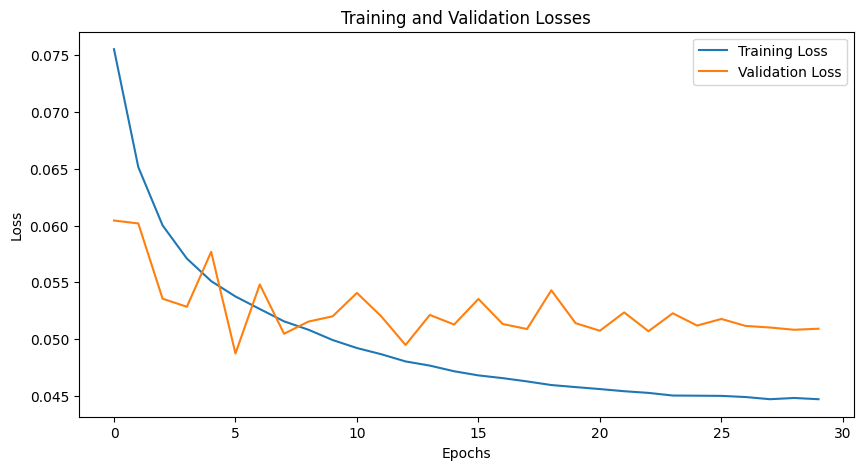

In [42]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [43]:
torch.save(model.state_dict(), "/content/drive/My Drive/AV Research/av_model.pt")

In [ ]:
from google.colab import runtime
runtime.unassign()